
# Paddy Yield Prediction Dataset

This dataset contains detailed agricultural information related to paddy cultivation, including soil characteristics, seed rate, fertilizer usage, irrigation patterns, weather conditions, and other agronomic factors. It is designed to support Machine Learning models that predict paddy yield and recommend suitable varieties. The goal is to help improve productivity and optimize resource usage by identifying key factors influencing crop performance.



## Loading the Data
The following table gives the description of each column along with their units.

| Name                     | Description                                      | Units          |
|--------------------------|--------------------------------------------------|---------------|
| Hectares                | Area of cultivation                              | hectares      |
| Agriblock               | Geographic block name                            | -             |
| Variety                 | Paddy variety name                               | -             |
| Soil Types              | Type of soil in the field                        | -             |
| Seedrate                | Seed rate used                                   | kg            |
| LP_Mainfield            | Land preparation material for main field         | tonnes        |
| Nursery                 | Type of nursery (dry/wet)                        | -             |
| Nursery area            | Area allocated for nursery                       | cents         |
| LP_nurseryarea          | Land preparation material for nursery area       | tonnes        |
| DAP_20days              | DAP fertilizer applied at 20 days                | kg            |
| Weed28D_thiobencarb     | Weedicide applied at 28 days                     | liters        |
| Urea_40Days             | Urea applied at 40 days                          | kg            |
| Potassh_50Days          | Potash applied at 50 days                        | kg            |
| Micronutrients_70Days   | Micronutrients applied at 70 days                | kg            |
| Pest_60Day              | Pesticide applied at 60 days                     | ml            |
| Rainfall & Irrigation   | Rainfall and irrigation data across growth stages| mm            |
| Temperature             | Minimum and maximum temperature across stages    | °C            |
| Wind Speed & Direction  | Instant wind speed and direction                 | knots / dir   |
| Relative Humidity       | Humidity across growth stages                    | %             |
| Trash                   | Trash bundles after harvest                      | bundles       |
| Paddy yield             | Final paddy yield                                | kg            |


## Checking for Missing values in the Dataset


In [5]:
""
# --- Basic imports ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Jupyter/visual settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# --- Load your dataset ---
file_path = "paddydataset.csv"  # ensure the file is in the working directory
df = pd.read_csv(file_path)

# --- Quick overview ---
print(f"Dataset Shape: {df.shape}")
print("\nColumn Names:")
print(df.columns.tolist())


# --- Basic data health checks ---
print("\nMissing Values (count per column):")
print(df.isna().sum())



Dataset Shape: (2789, 45)

Column Names:
['Hectares ', 'Agriblock', 'Variety', 'Soil Types', 'Seedrate(in Kg)', 'LP_Mainfield(in Tonnes)', 'Nursery', 'Nursery area (Cents)', 'LP_nurseryarea(in Tonnes)', 'DAP_20days', 'Weed28D_thiobencarb', 'Urea_40Days', 'Potassh_50Days', 'Micronutrients_70Days', 'Pest_60Day(in ml)', '30DRain( in mm)', '30DAI(in mm)', '30_50DRain( in mm)', '30_50DAI(in mm)', '51_70DRain(in mm)', '51_70AI(in mm)', '71_105DRain(in mm)', '71_105DAI(in mm)', 'Min temp_D1_D30', 'Max temp_D1_D30', 'Min temp_D31_D60', 'Max temp_D31_D60', 'Min temp_D61_D90', 'Max temp_D61_D90', 'Min temp_D91_D120', 'Max temp_D91_D120', 'Inst Wind Speed_D1_D30(in Knots)', 'Inst Wind Speed_D31_D60(in Knots)', 'Inst Wind Speed_D61_D90(in Knots)', 'Inst Wind Speed_D91_D120(in Knots)', 'Wind Direction_D1_D30', 'Wind Direction_D31_D60', 'Wind Direction_D61_D90', 'Wind Direction_D91_D120', 'Relative Humidity_D1_D30', 'Relative Humidity_D31_D60', 'Relative Humidity_D61_D90', 'Relative Humidity_D91_D12


## Features to Use for Prediction

The following features were selected using a systematic feature selection process combining **statistical dependence** and **model-based importance**:

### **Selection Methodology**
1. **Data Preprocessing**
   - Removed leakage columns (e.g., `Trash(in bundles)`), duplicates, constant and near-constant features.
   - Categorical variables were one-hot encoded using `OneHotEncoder` to create binary indicators for each category.

2. **Feature Scoring**
   - **Mutual Information (MI):**  
     Measures the dependency between each feature and the target (`Paddy yield(in Kg)`), capturing both linear and non-linear relationships.
   - **Random Forest Importance:**  
     A model-based metric that evaluates how much each feature reduces prediction error across decision trees.

3. **Top-K Union**
   - Selected the **top 25 features** from MI ranking and the **top 25 features** from Random Forest ranking.
   - Combined both sets to form a union, ensuring that features strong in either metric are retained.

4. **Mapping Back to Original Columns**
   - For one-hot encoded features (e.g., `Variety_CO_43`), the parent column (`Variety`) was included in the final feature set.

### **Why This Approach?**
- MI captures any statistical association, even if non-linear.
- Random Forest importance reflects predictive power in a tree-based model.
- Combining both reduces bias and avoids dropping features that matter in different contexts.

The final set of features includes agronomic inputs, environmental conditions, and categorical factors that showed the highest relevance for predicting paddy yield.


In [9]:

# --- Imports ---
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

# --- Load dataset ---
df = pd.read_csv("paddydataset.csv")

# --- Target and initial safe drops ---
TARGET = "Paddy yield(in Kg)"
leakage_cols = ["Trash(in bundles)"]  # post-harvest; can leak target
drop_present = [c for c in leakage_cols if c in df.columns]
df = df.drop(columns=drop_present)

print("Dropped leakage columns:", drop_present)

# --- Basic cleaning: duplicate, constant, near-constant ---
# 1) Remove exact duplicate columns
df = df.loc[:, ~df.T.duplicated()]
print("Shape after removing duplicate columns:", df.shape)

# 2) Remove constant columns
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1 and c != TARGET]
if constant_cols:
    df = df.drop(columns=constant_cols)
print("Dropped constant columns:", constant_cols)

# 3) Remove near-constant numeric columns (dominant single value > 98%)
near_constant = []
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    if c == TARGET:
        continue
    vc = df[c].value_counts(dropna=False)
    if len(vc) > 0 and (vc.iloc[0] / len(df)) > 0.98:
        near_constant.append(c)
if near_constant:
    df = df.drop(columns=near_constant)
print("Dropped near-constant numeric columns:", near_constant)

# --- Prepare X, y and identify column types ---
y = df[TARGET].values
X = df.drop(columns=[TARGET])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Strip whitespace in categorical columns (safer encoding)
for c in cat_cols:
    X[c] = X[c].astype(str).str.strip()

# --- Column transformer: OneHot for categoricals, pass-through numeric ---
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop"
)

# --- Create a numeric design matrix for feature scoring ---
X_encoded = preprocess.fit_transform(X)

# Build feature name mapping from ColumnTransformer
encoded_feature_names = []
# Numeric columns first (pass-through)
encoded_feature_names.extend(num_cols)
# Then one-hot columns with categories
if cat_cols:
    cat_feature_names = preprocess.named_transformers_["cat"].get_feature_names_out(cat_cols)
    encoded_feature_names.extend(cat_feature_names.tolist())

# --- Feature scoring: Mutual Information ---
mi_scores = mutual_info_regression(X_encoded, y, random_state=42)
mi_rank = np.argsort(mi_scores)[::-1]  # indices sorted by importance desc

# --- Feature scoring: Random Forest ---
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None
)
rf.fit(X_encoded, y)
rf_scores = rf.feature_importances_
rf_rank = np.argsort(rf_scores)[::-1]

# --- Select top-k features by both methods and take union ---
TOP_K = 25  # tune as needed
top_mi_idx = mi_rank[:TOP_K]
top_rf_idx = rf_rank[:TOP_K]
selected_idx = sorted(set(top_mi_idx).union(set(top_rf_idx)))

selected_feature_names = [encoded_feature_names[i] for i in selected_idx]

print(f"\nSelected top {TOP_K} features (union of MI & RF):")
for name in selected_feature_names:
    print("-", name)

# --- Map selected encoded features back to original columns to drop unimportant ones ---
# Strategy: keep original columns that contribute to selected encoded features
# For numeric features: they map 1:1
keep_original = set(num_cols)

# For one-hot features: names look like "Variety_CO_43", "Soil Types_clay", etc.
# Extract the source column before the underscore separator used by sklearn's get_feature_names_out
for feat in selected_feature_names:
    # If it's a numeric original column
    if feat in num_cols:
        keep_original.add(feat)
    else:
        # one-hot column format: "<col>_<category>"
        # find the original col name that prefixes the feature name
        for c in cat_cols:
            if feat.startswith(c + "_"):
                keep_original.add(c)
                break

keep_original = list(keep_original)

# Ensure we keep the target
columns_to_keep = keep_original + [TARGET]
columns_to_keep = list(dict.fromkeys(columns_to_keep))  # de-dupe

# Final reduced dataframe
df_reduced = df[columns_to_keep].copy()

print("\nOriginal columns:", len(df.columns))
print("Kept columns:", len(columns_to_keep))
print("Dropped columns:", len(df.columns) - len(columns_to_keep))
print("Columns kept:", columns_to_keep)


Dropped leakage columns: ['Trash(in bundles)']
Shape after removing duplicate columns: (2789, 43)
Dropped constant columns: []
Dropped near-constant numeric columns: []

Selected top 25 features (union of MI & RF):
- Hectares 
- Seedrate(in Kg)
- LP_Mainfield(in Tonnes)
- Nursery area (Cents)
- DAP_20days
- Weed28D_thiobencarb
- Urea_40Days
- Potassh_50Days
- Micronutrients_70Days
- Pest_60Day(in ml)
- 51_70AI(in mm)
- Min temp_D1_D30
- Max temp_D1_D30
- Min temp_D31_D60
- Max temp_D31_D60
- Min temp_D61_D90
- Max temp_D61_D90
- Min temp_D91_D120
- Inst Wind Speed_D1_D30(in Knots)
- Inst Wind Speed_D91_D120(in Knots)
- Relative Humidity_D1_D30
- Relative Humidity_D31_D60
- Relative Humidity_D61_D90
- Relative Humidity_D91_D120
- Variety_CO_43
- Variety_delux ponni
- Variety_ponmani
- Soil Types_alluvial
- Soil Types_clay
- Nursery_dry
- Nursery_wet
- Wind Direction_D1_D30_SSE
- Wind Direction_D61_D90_SE

Original columns: 43
Kept columns: 40
Dropped columns: 3
Columns kept: ['Urea_40Da


## Target and Features

**Target Variable:**  
- `Paddy yield(in Kg)`  
This represents the total yield of paddy harvested from the field and is the primary outcome we aim to predict.

**Features Used for Prediction:**  
The model will utilize the most informative agronomic, environmental, and categorical factors identified through feature selection (Mutual Information + Random Forest importance):

### **Agronomic Inputs**
- `Hectares` – Cultivation area  
- `Seedrate(in Kg)` – Seed quantity used  
- `LP_Mainfield(in Tonnes)` – Land preparation material for main field  
- `Nursery area (Cents)` – Nursery size  
- Fertilizer applications:  
  - `DAP_20days`  
  - `Urea_40Days`  
  - `Potassh_50Days`  
  - `Micronutrients_70Days`  
- `Weed28D_thiobencarb` – Weedicide application  
- `Pest_60Day(in ml)` – Pesticide usage  

### **Environmental Conditions**
- Irrigation/Rainfall:  
  - `51_70AI(in mm)` – Irrigation during mid-growth stage  
- Temperature ranges:  
  - `Min temp_D1_D30`, `Max temp_D1_D30`  
  - `Min temp_D31_D60`, `Max temp_D31_D60`  
  - `Min temp_D61_D90`, `Max temp_D61_D90`  
  - `Min temp_D91_D120`  
- Wind speed:  
  - `Inst Wind Speed_D1_D30(in Knots)`  
  - `Inst Wind Speed_D91_D120(in Knots)`  
- Relative humidity across stages:  
  - `Relative Humidity_D1_D30`, `Relative Humidity_D31_D60`, `Relative Humidity_D61_D90`, `Relative Humidity_D91_D120`  

### **Categorical Factors**
- `Variety` – Paddy variety (CO_43, ponmani, delux ponni)  
- `Soil Types` – Soil classification (alluvial, clay)  
- `Nursery` – Type of nursery (dry, wet)  
- Wind direction indicators:  
  - `Wind Direction_D1_D30_SSE`  
  - `Wind Direction_D61_D90_SE`  

These features were selected because they showed the strongest statistical dependence and predictive power for yield, based on **Mutual Information** and **Random Forest feature importance**.


## Outlier Detection

In [15]:

# =========================
# Define df_top25 directly from df_reduced and expose `data`
# =========================

# Safety checks: ensure df_reduced exists and includes the target
TARGET = "Paddy yield(in Kg)"

try:
    df_reduced  # should already be created by your feature selection cell
except NameError as e:
    raise RuntimeError(
        "df_reduced was not found. Please run the feature selection cell first "
        "to create df_reduced (the reduced dataframe with top features + target)."
    ) from e

if TARGET not in df_reduced.columns:
    raise ValueError(f"Target column '{TARGET}' not found in df_reduced. "
                     "Verify the selection cell created df_reduced correctly.")

# Optional: ensure we roughly have ~25 features (parents) + target
# (This count depends on how many categorical parents were kept.)
feature_count = len([c for c in df_reduced.columns if c != TARGET])
print(f"[Info] Parent features in df_reduced: {feature_count}")

# Define df_top25 as the final, canonical feature set
df_top25 = df_reduced.copy()

# For consistency across your notebook, use `data` everywhere downstream
data = df_top25.copy()

# Status & quick overview
print("[Info] df_top25 defined from df_reduced.")
print("[Info] `data` set to df_top25 for all future steps.")
print("[Info] Shape:", data.shape)
print("[Info] Numeric cols:", len(data.select_dtypes(include=['number']).columns))
print("[Info] Categorical cols:", len(data.select_dtypes(exclude=['number']).columns))

# Optional: rename trailing-space columns to avoid KeyError later (seen in some dumps)
# e.g., "Hectares " -> "Hectares"
data = data.rename(columns=lambda c: c.strip())

# If you prefer to persist the final set:
# data.to_csv("paddydataset_top25.csv", index=False)


[Info] Parent features in df_reduced: 39
[Info] df_top25 defined from df_reduced.
[Info] `data` set to df_top25 for all future steps.
[Info] Shape: (2789, 40)
[Info] Numeric cols: 35
[Info] Categorical cols: 5


Using 34 numeric feature columns for outlier detection.
Columns: ['Urea_40Days', 'Hectares ', '71_105DAI(in mm)', 'Min temp_D1_D30', '30_50DRain( in mm)', 'Inst Wind Speed_D31_D60(in Knots)', 'Max temp_D1_D30', 'Relative Humidity_D61_D90', 'Weed28D_thiobencarb', 'Min temp_D61_D90', 'Relative Humidity_D31_D60', '51_70AI(in mm)', 'Potassh_50Days', 'DAP_20days', 'Relative Humidity_D91_D120', 'Micronutrients_70Days', 'Nursery area (Cents)', '71_105DRain(in mm)', 'Max temp_D31_D60', 'Max temp_D61_D90', '30_50DAI(in mm)', 'Max temp_D91_D120', 'Min temp_D31_D60', 'Inst Wind Speed_D61_D90(in Knots)', 'Seedrate(in Kg)', '30DRain( in mm)', 'Inst Wind Speed_D91_D120(in Knots)', 'Pest_60Day(in ml)', 'Min temp_D91_D120', '30DAI(in mm)', 'Inst Wind Speed_D1_D30(in Knots)', 'LP_Mainfield(in Tonnes)', 'Relative Humidity_D1_D30', '51_70DRain(in mm)']
IQR outliers (any feature): 425 rows
Z-score outliers (|z|>3, any feature): 0 rows

Summary:
- IQR flagged rows: 425
- Z-score flagged rows: 0
- Union (an

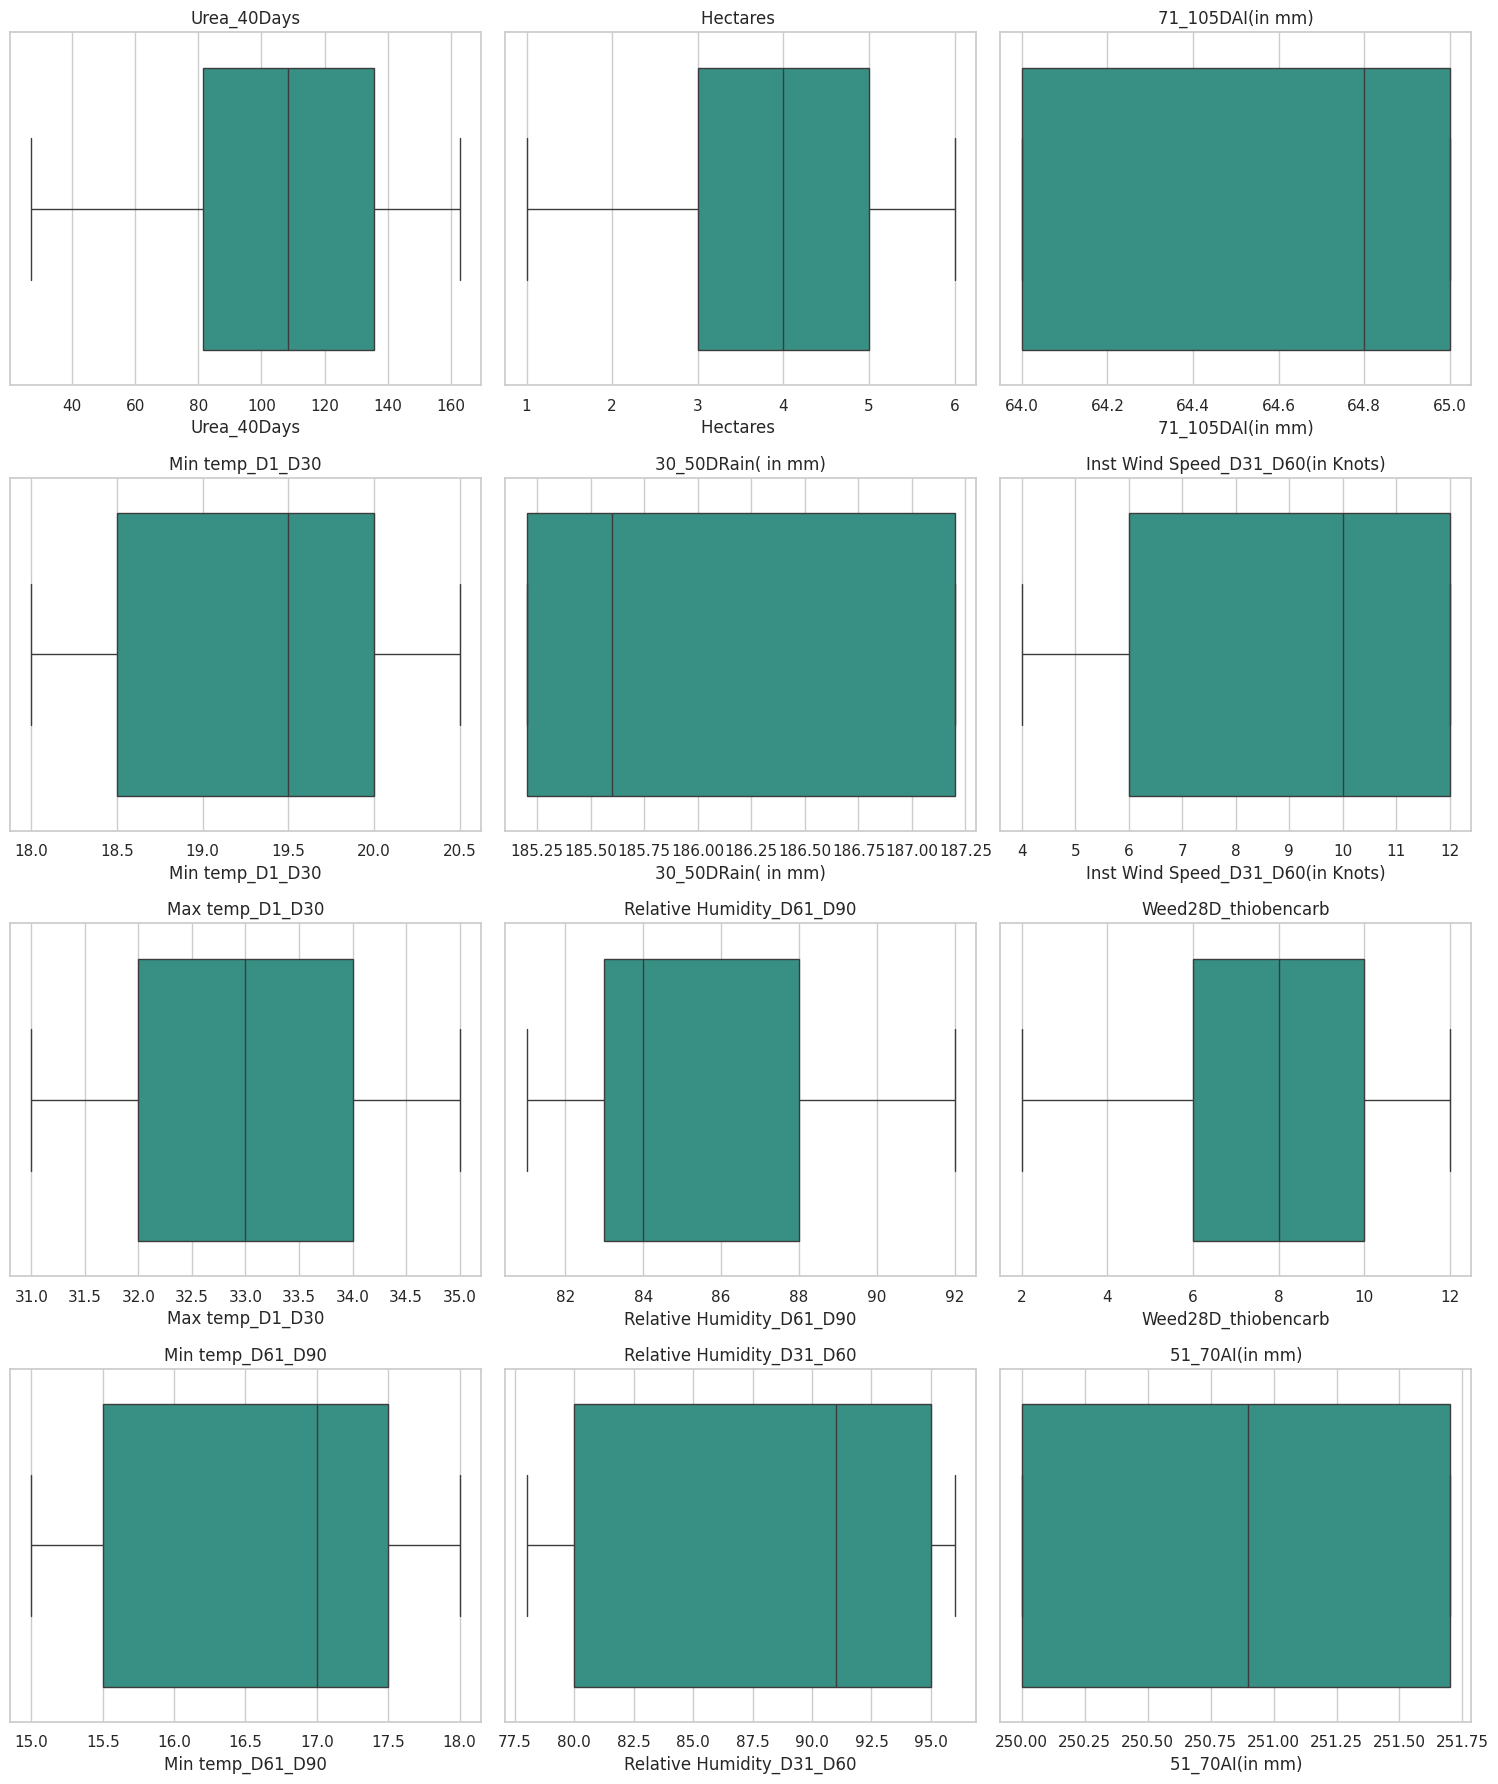

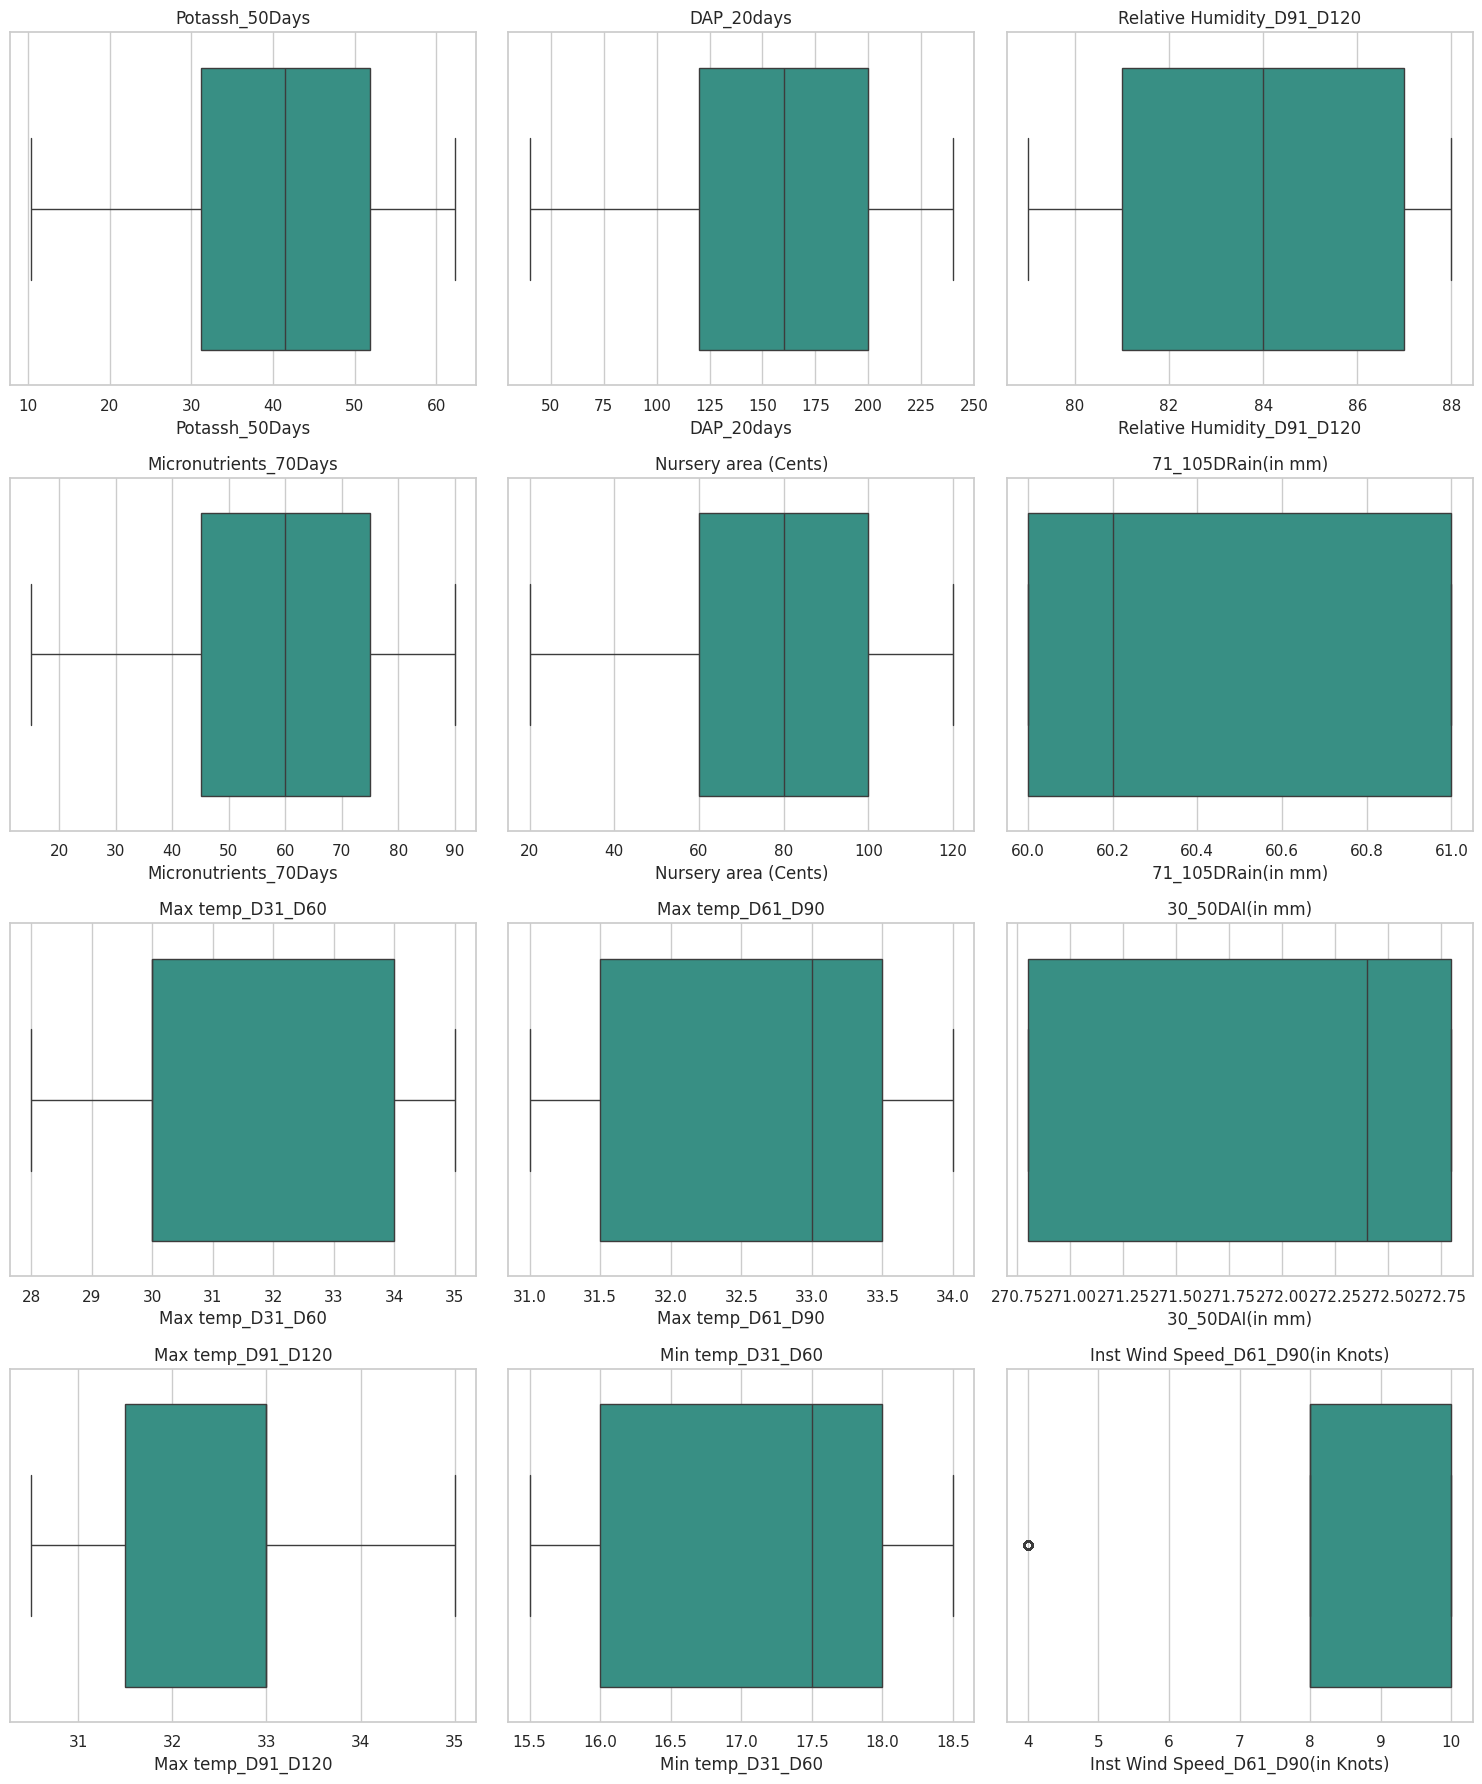

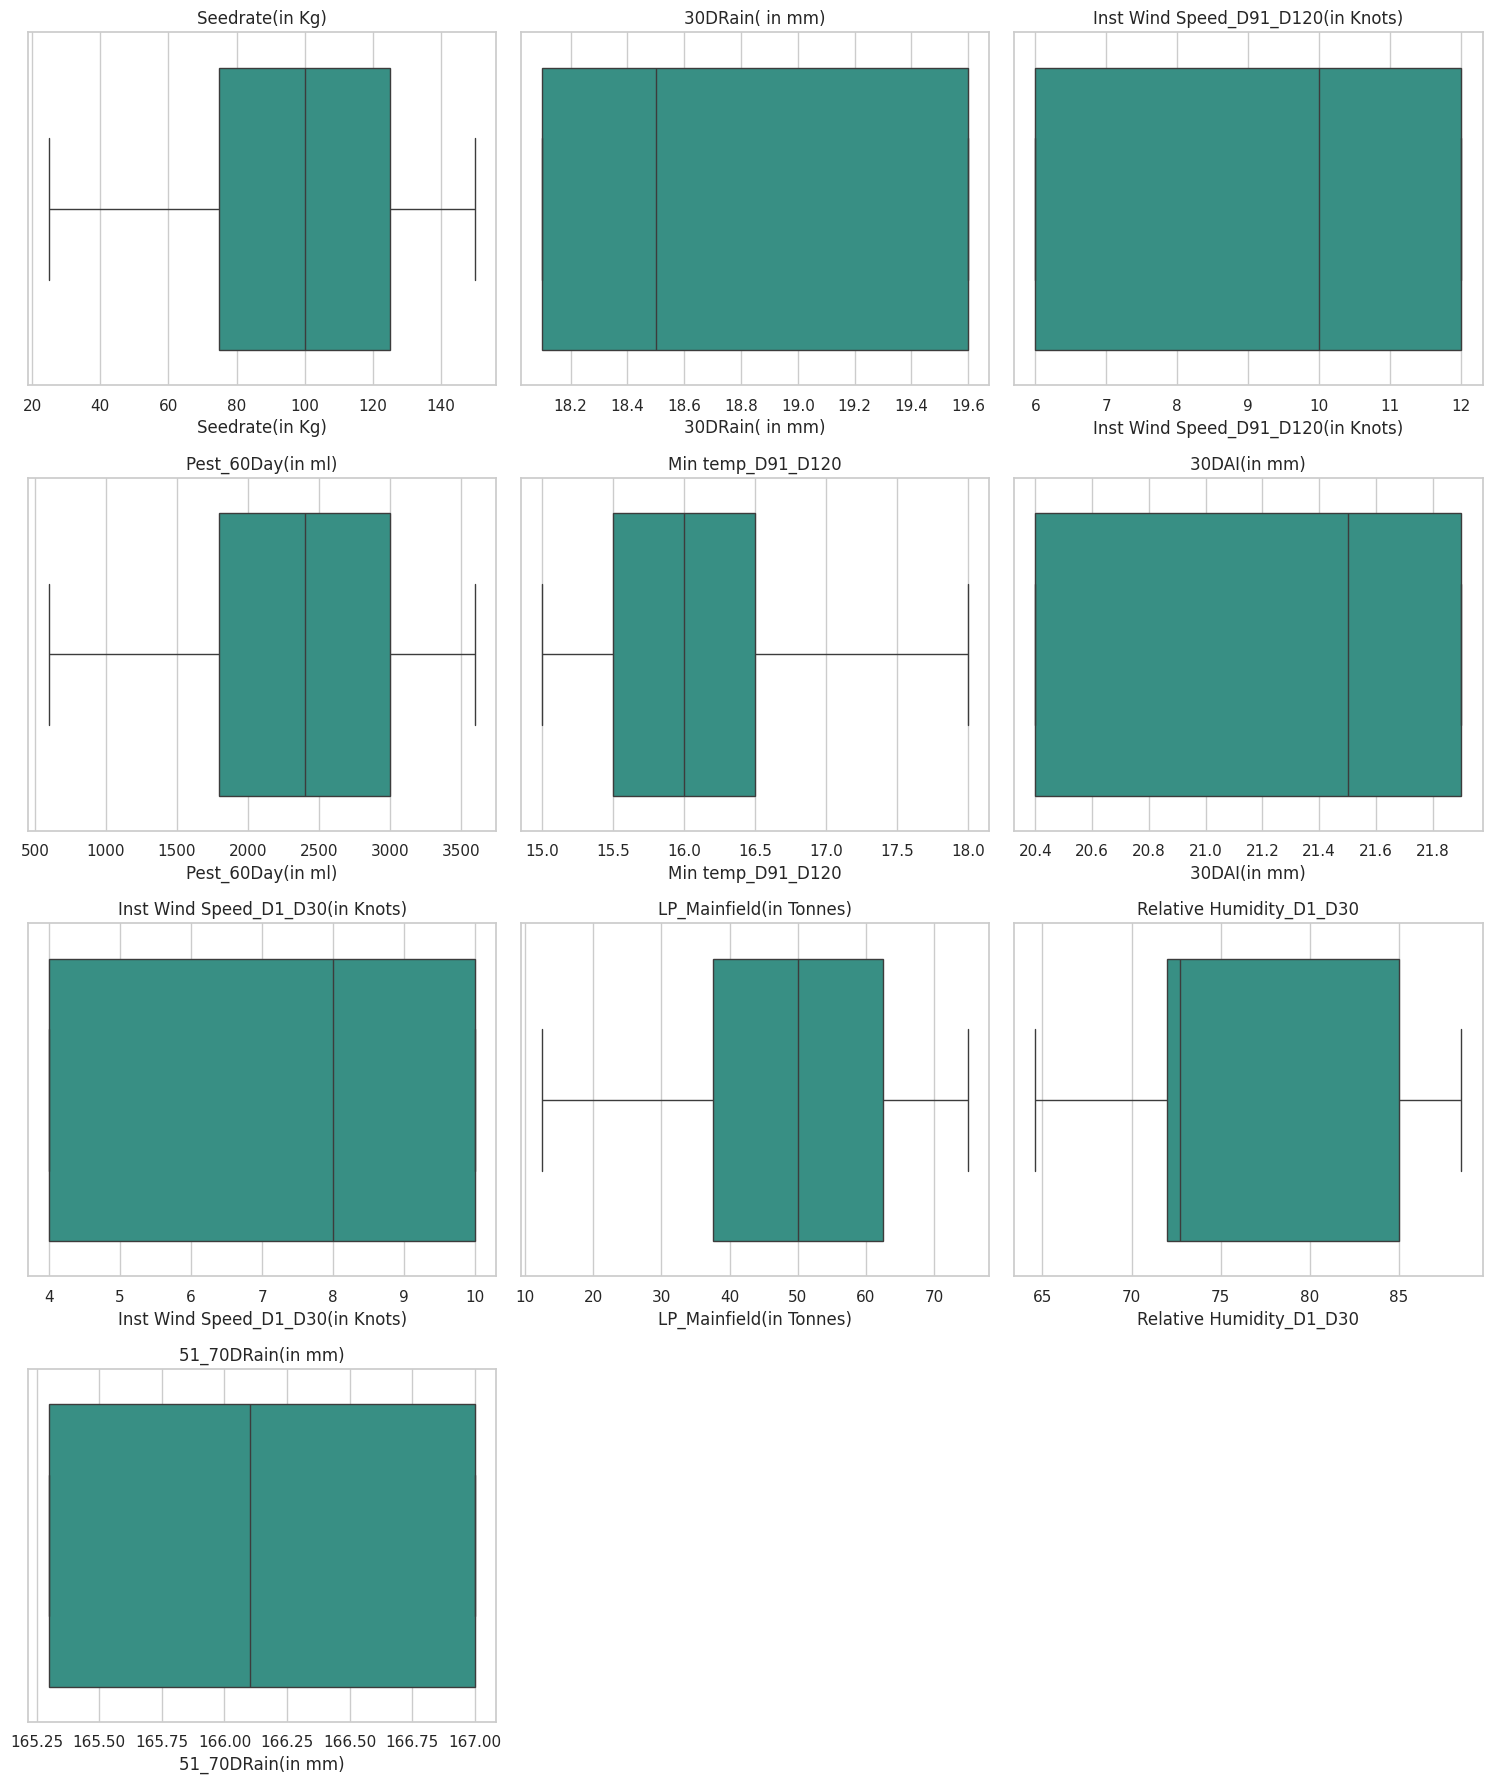

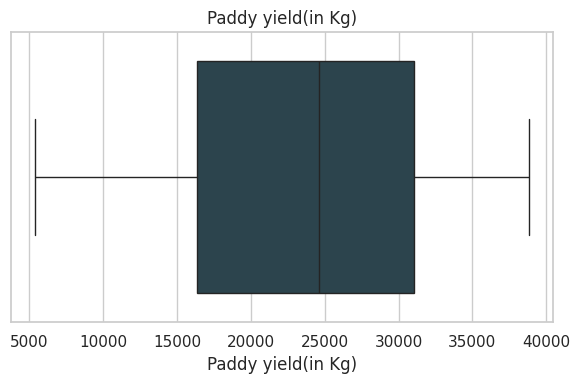

In [18]:

# =========================
# Outlier Detection (IQR & Z-score) + Boxplots
# =========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# --- Choose dataframe: reduced (top-25) if exists, else original ---
try:
    data = df_top25.copy()
except NameError:
    try:
        data = df_reduced.copy()
    except NameError:
        data = df.copy()

TARGET = "Paddy yield(in Kg)"

# --- Numeric columns (features only for outlier detection) ---
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

print(f"Using {len(feature_cols)} numeric feature columns for outlier detection.")
print("Columns:", feature_cols)

# ---------- IQR method ----------
def iqr_outliers(df, cols, k=1.5):
    flags = pd.DataFrame(index=df.index)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        flags[c] = (df[c] < lower) | (df[c] > upper)
    # Row flagged if any column is flagged
    return flags.any(axis=1), flags

iqr_union_flags, iqr_percol_flags = iqr_outliers(data, feature_cols, k=1.5)
print(f"IQR outliers (any feature): {iqr_union_flags.sum()} rows")

# ---------- Z-score method ----------
def zscore_outliers(df, cols, z=3.0):
    flags = pd.DataFrame(index=df.index)
    for c in cols:
        mu = df[c].mean()
        sigma = df[c].std(ddof=0)
        if sigma == 0 or np.isnan(sigma):
            flags[c] = False
        else:
            zscores = (df[c] - mu) / sigma
            flags[c] = zscores.abs() > z
    return flags.any(axis=1), flags

z_union_flags, z_percol_flags = zscore_outliers(data, feature_cols, z=3.0)
print(f"Z-score outliers (|z|>3, any feature): {z_union_flags.sum()} rows")

# ---------- Combine results ----------
outlier_df = pd.DataFrame({
    "IQR_outlier_any": iqr_union_flags,
    "Z_outlier_any": z_union_flags
})
outlier_df["Any_outlier"] = outlier_df.any(axis=1)

# Row indices flagged by each method and union
iqr_idx = outlier_df.index[outlier_df["IQR_outlier_any"]].tolist()
z_idx = outlier_df.index[outlier_df["Z_outlier_any"]].tolist()
union_idx = outlier_df.index[outlier_df["Any_outlier"]].tolist()

print("\nSummary:")
print(f"- IQR flagged rows: {len(iqr_idx)}")
print(f"- Z-score flagged rows: {len(z_idx)}")
print(f"- Union (any method) flagged rows: {len(union_idx)}")

def plot_boxplots(df, cols, per_fig=12, rows=4, cols_in_grid=3):
    pages = (len(cols) + per_fig - 1) // per_fig
    for p in range(pages):
        subset = cols[p*per_fig : min((p+1)*per_fig, len(cols))]
        plt.figure(figsize=(15, 18))
        for i, col in enumerate(subset, 1):
            plt.subplot(rows, cols_in_grid, i)
            sns.boxplot(x=df[col], color="#2a9d8f")
            plt.title(col)
            plt.xlabel(col)
        # turn off unused axes
        for j in range(len(subset)+1, rows*cols_in_grid+1):
            plt.subplot(rows, cols_in_grid, j)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

plot_boxplots(data, feature_cols)

# ---------- Optional: Boxplot for target as well ----------
if TARGET in data.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[TARGET], color="#264653")
    plt.title(TARGET)
    plt.xlabel(TARGET)
    plt.tight_layout()
    plt.show()


## Removing Outlier Flagged rows

[IQR] Total rows: 2789
[IQR] Flagged rows to drop: 425
[IQR] Rows after removal: 2364

[Info] Cleaned dataframe shape: (2364, 40)
[Info] Columns (first 10): ['Urea_40Days', 'Hectares ', 'Variety', '71_105DAI(in mm)', 'Wind Direction_D61_D90', 'Min temp_D1_D30', '30_50DRain( in mm)', 'Inst Wind Speed_D31_D60(in Knots)', 'Max temp_D1_D30', 'Relative Humidity_D61_D90']


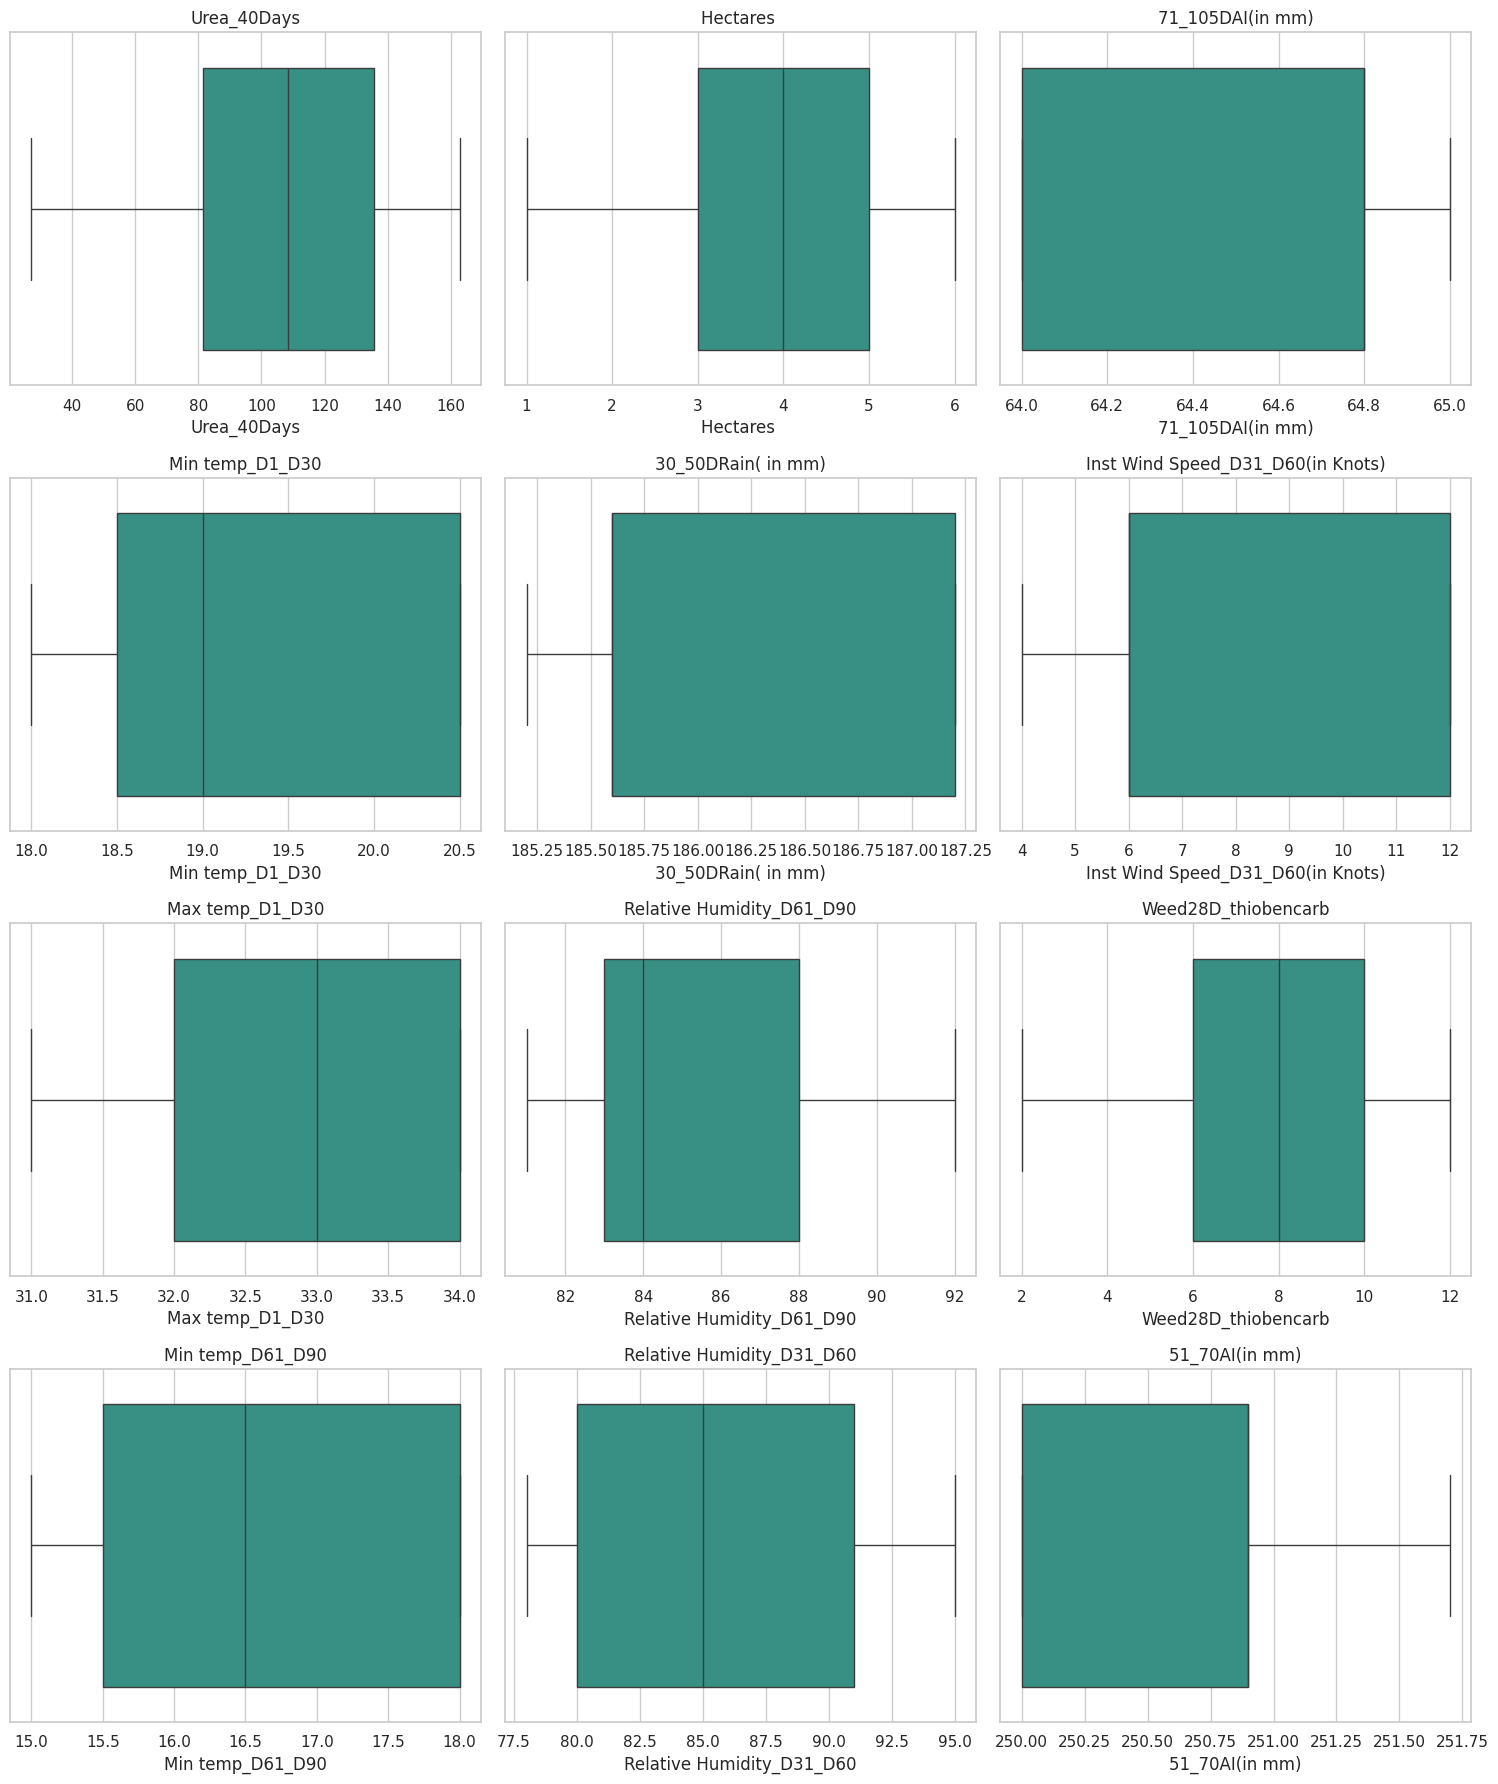

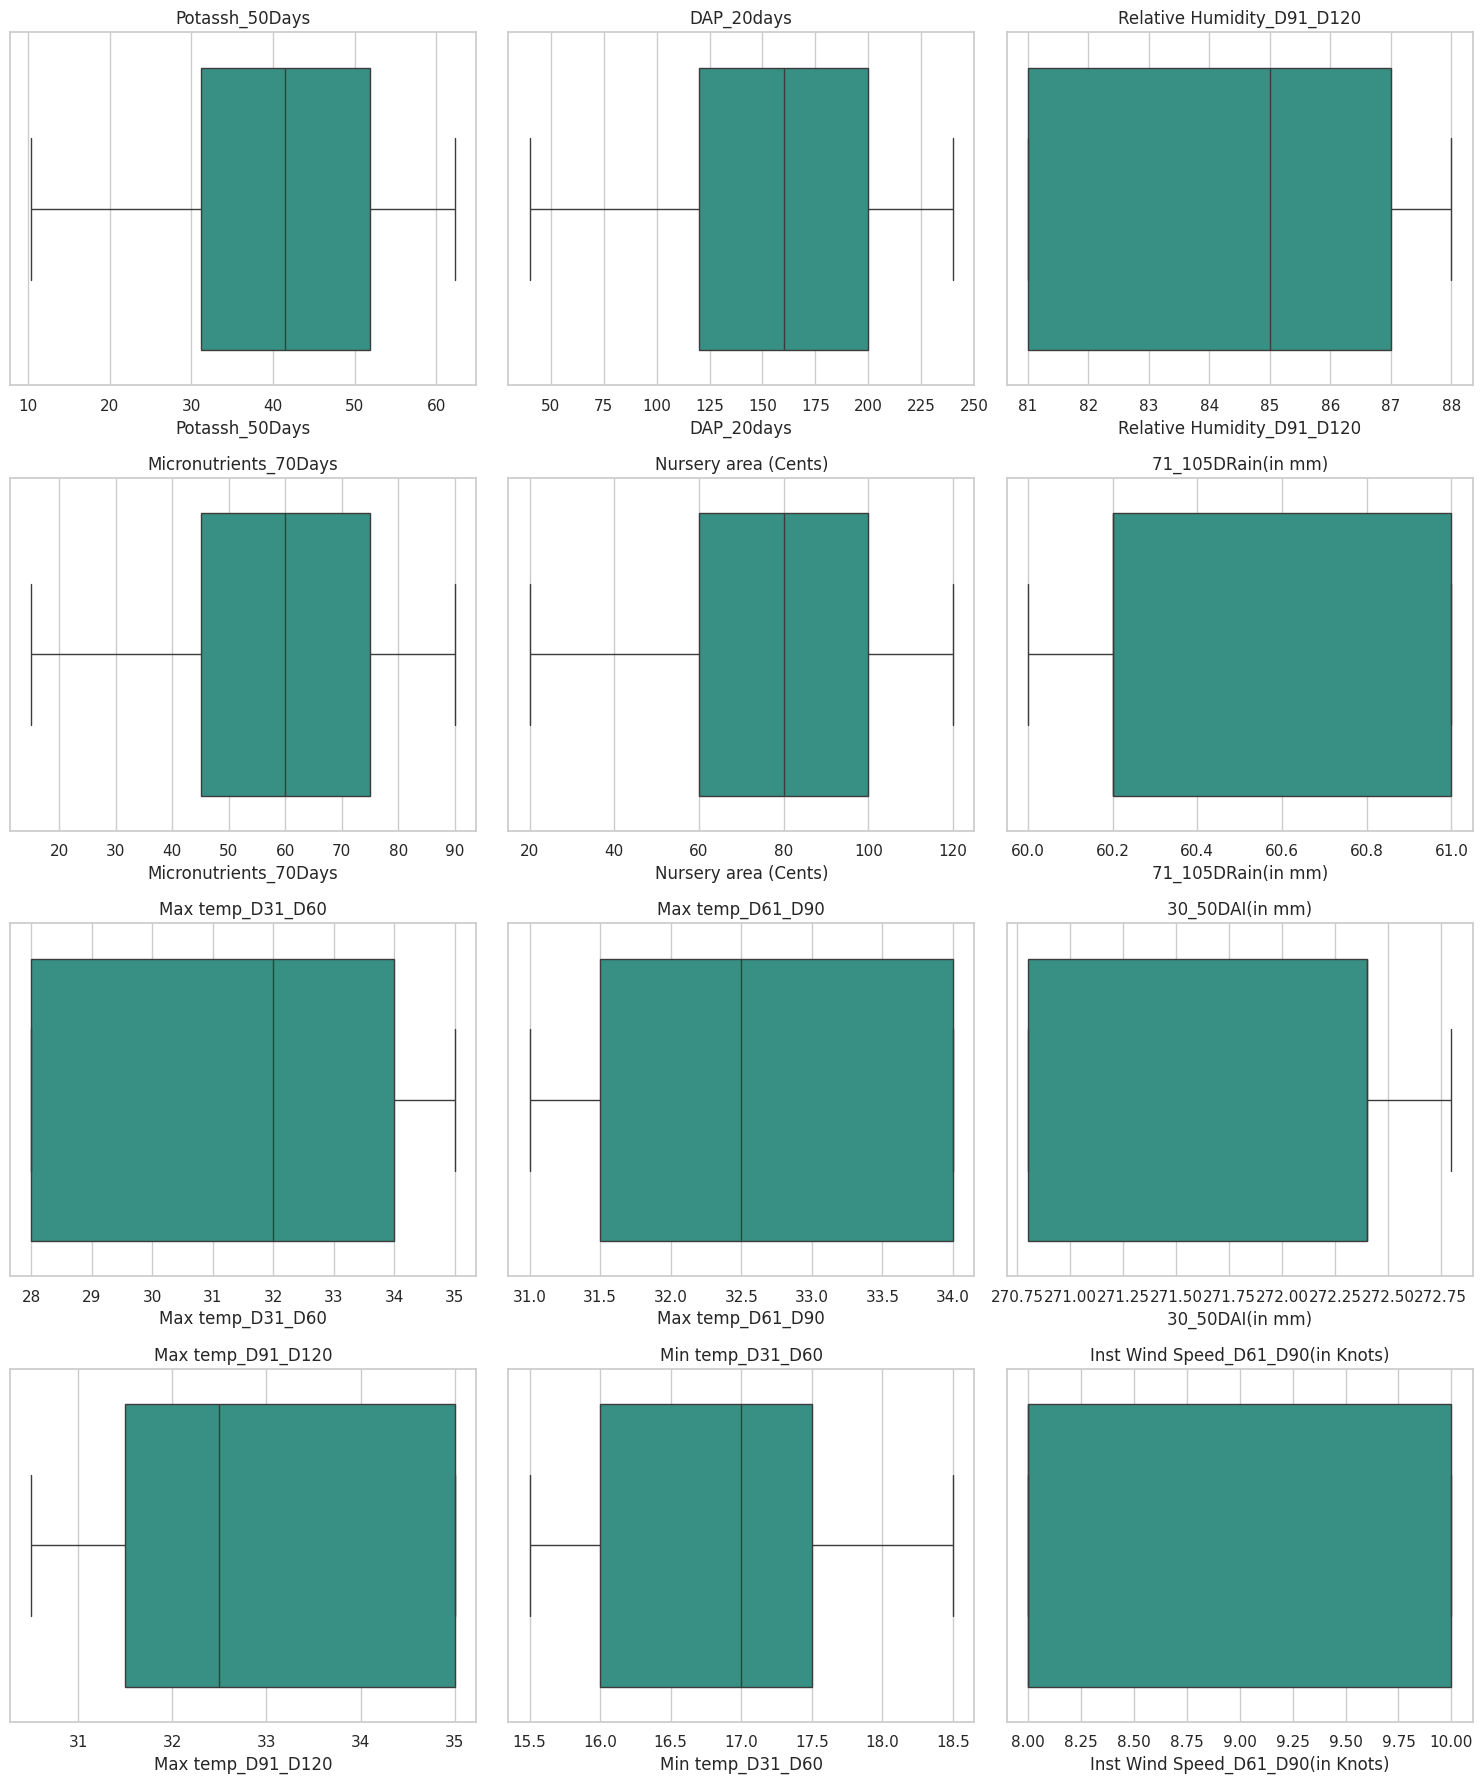

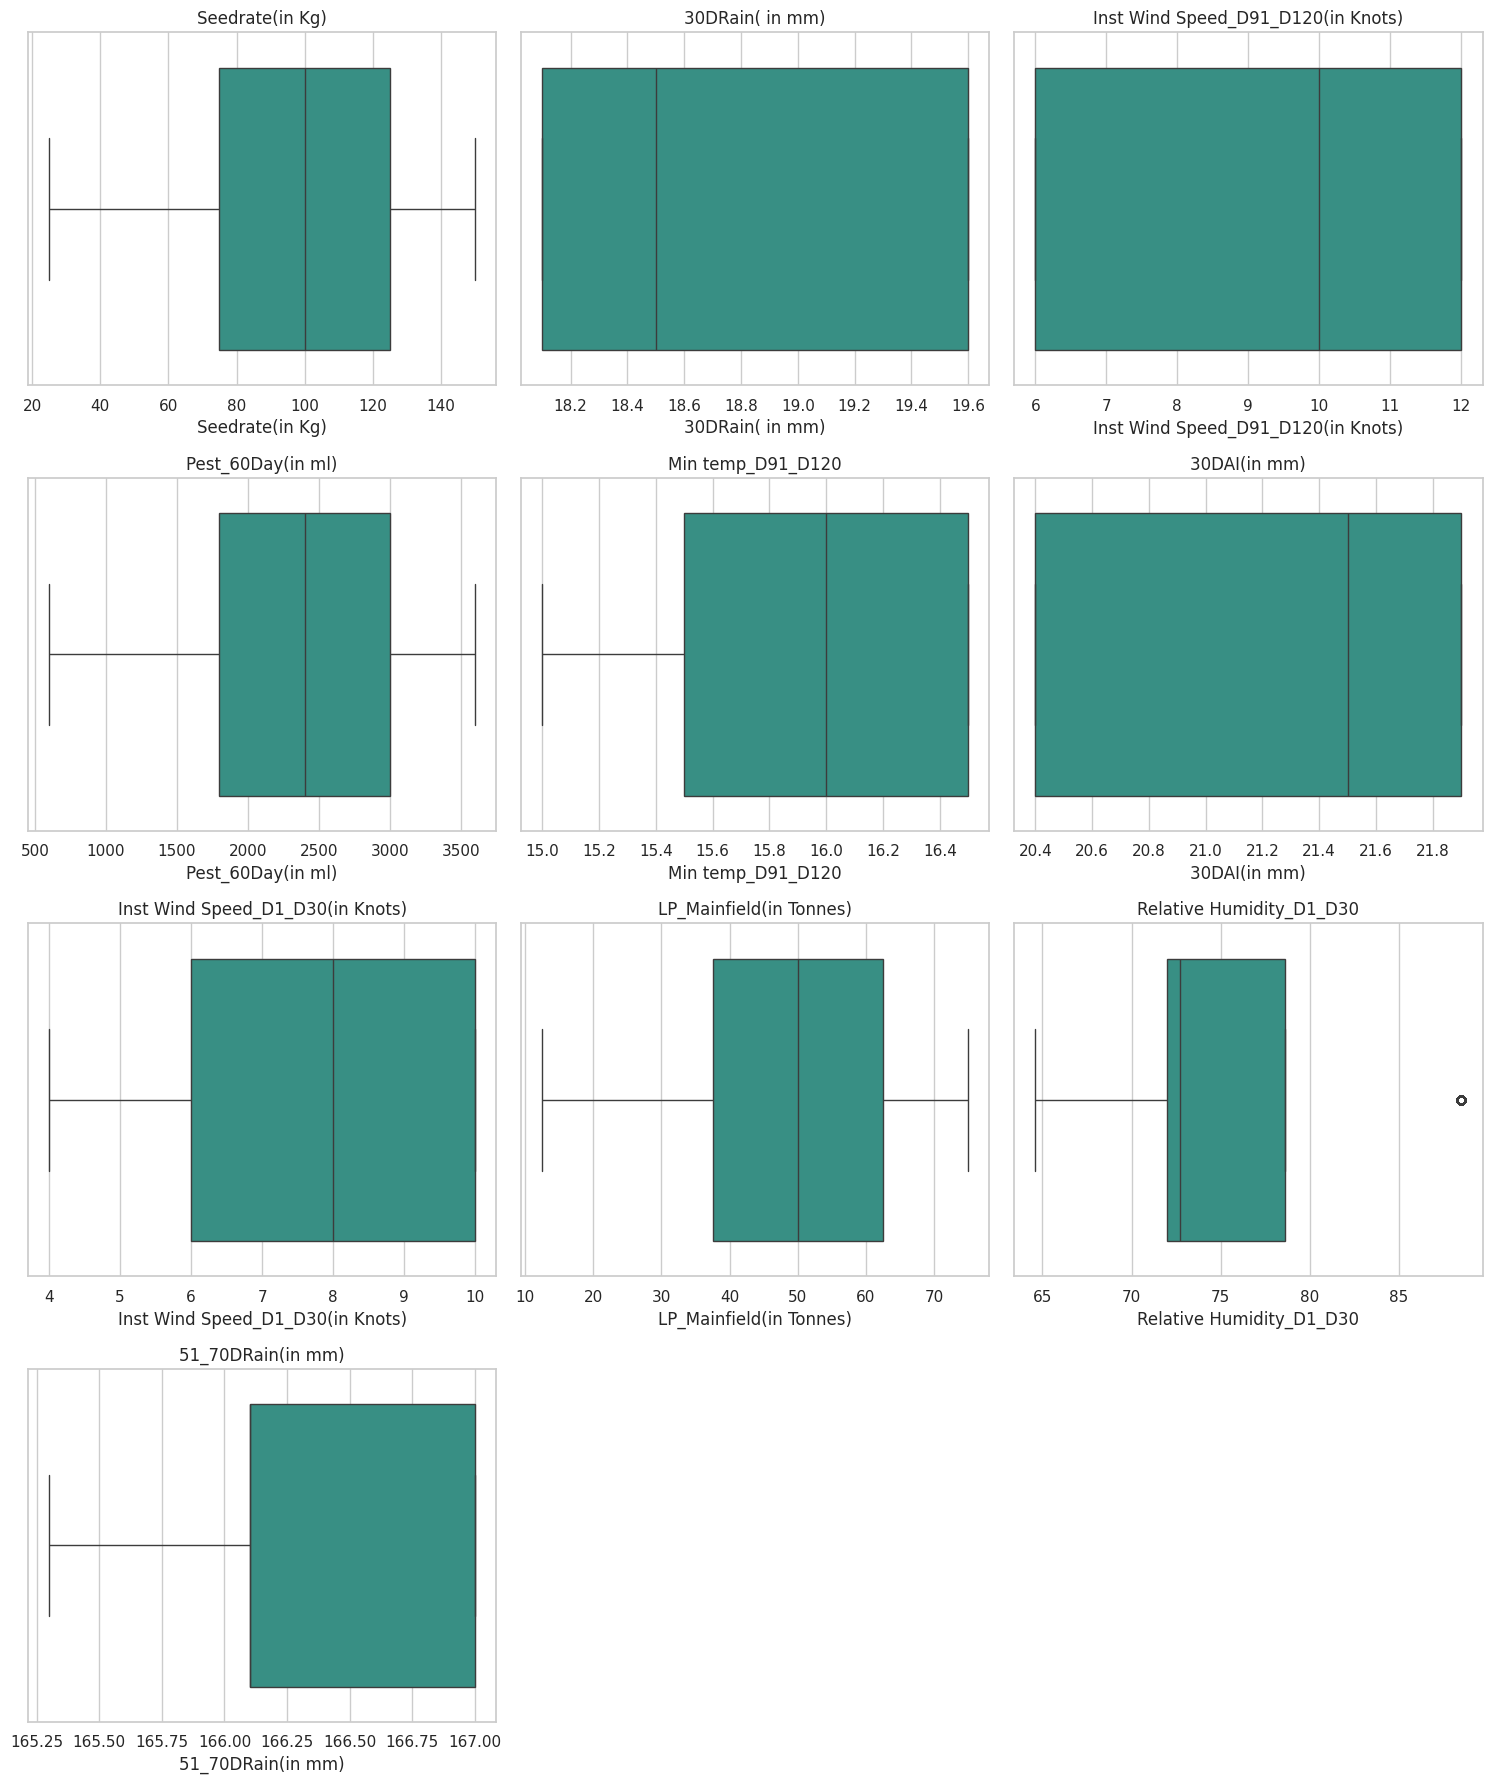

In [20]:

# =========================
# Remove IQR-flagged outlier rows
# =========================
import pandas as pd
import numpy as np

# Use your canonical dataframe
try:
    base_df = data.copy()           # preferred: df_top25
except NameError:
    try:
        base_df = df_top25.copy()   # fallback
    except NameError:
        try:
            base_df = df_reduced.copy()
        except NameError:
            base_df = df.copy()

TARGET = "Paddy yield(in Kg)"

# Numeric feature columns (exclude target)
numeric_cols = base_df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

# IQR outlier function (redefine if not in scope)
def iqr_outliers(df, cols, k=1.5):
    flags = pd.DataFrame(index=df.index)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        flags[c] = (df[c] < lower) | (df[c] > upper)
    return flags.any(axis=1), flags  # row-level union, per-column flags

# Compute IQR flags
iqr_union_flags, iqr_percol_flags = iqr_outliers(base_df, feature_cols, k=1.5)

n_total = len(base_df)
n_outliers = int(iqr_union_flags.sum())
print(f"[IQR] Total rows: {n_total}")
print(f"[IQR] Flagged rows to drop: {n_outliers}")

# Remove the IQR outliers
clean_df = base_df.loc[~iqr_union_flags].copy()
n_clean = len(clean_df)
print(f"[IQR] Rows after removal: {n_clean}")

# Set canonical cleaned frames for future use
data_clean = clean_df              # use this instead of `data` going forward if you want to work without outliers
df_top25_clean = clean_df.copy()   # alias for clarity in future cells

# Optional: quick sanity check of target and a few columns
print("\n[Info] Cleaned dataframe shape:", clean_df.shape)
print("[Info] Columns (first 10):", clean_df.columns[:10].tolist())

# Optional: save to CSV for reproducibility
# clean_df.to_csv("paddydataset_top25_no_IQR_outliers.csv", index=False)

# OPTIONAL: Boxplot grid on cleaned data (uncomment to visualize)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
def plot_boxplots(df, cols, per_fig=12, rows=4, cols_in_grid=3):
    pages = (len(cols) + per_fig - 1) // per_fig
    for p in range(pages):
        subset = cols[p*per_fig : min((p+1)*per_fig, len(cols))]
        plt.figure(figsize=(15, 18))
        for i, col in enumerate(subset, 1):
            plt.subplot(rows, cols_in_grid, i)
            sns.boxplot(x=df[col], color="#2a9d8f")
            plt.title(col)
            plt.xlabel(col)
        for j in range(len(subset)+1, rows*cols_in_grid+1):
            plt.subplot(rows, cols_in_grid, j)
            plt.axis("off")
        plt.tight_layout()
        plt.show()
plot_boxplots(clean_df, feature_cols)


## Correlation HeatMap

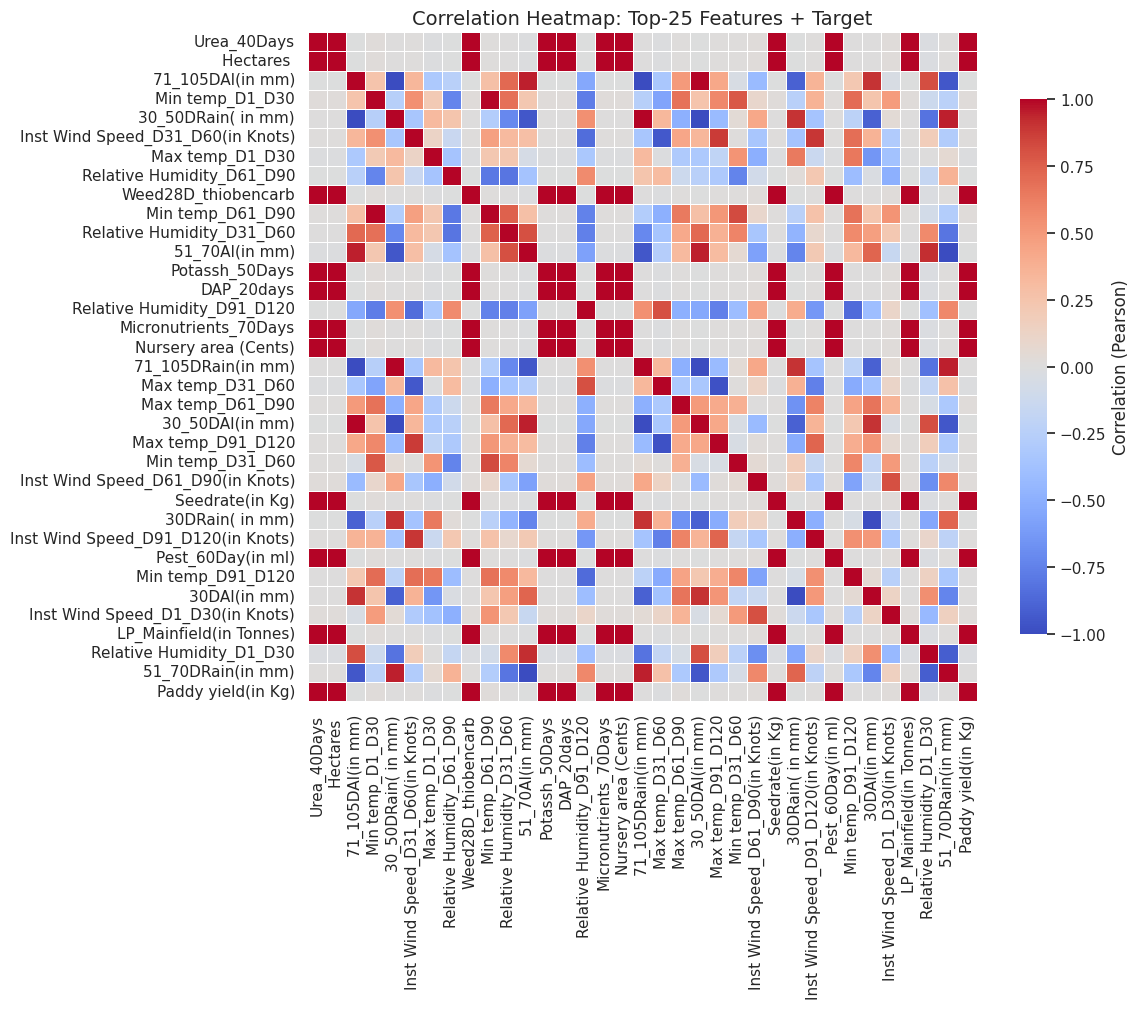


Top 10 positive correlations with target:
Urea_40Days                0.994649
Hectares                   0.994649
Weed28D_thiobencarb        0.994649
Potassh_50Days             0.994649
DAP_20days                 0.994649
Nursery area (Cents)       0.994649
Micronutrients_70Days      0.994649
Seedrate(in Kg)            0.994649
LP_Mainfield(in Tonnes)    0.994649
Pest_60Day(in ml)          0.994649
Name: Paddy yield(in Kg), dtype: float64

Top 10 negative correlations with target:
30_50DRain( in mm)            0.001892
71_105DAI(in mm)             -0.001892
30_50DAI(in mm)              -0.001892
30DRain( in mm)              -0.006570
Relative Humidity_D91_D120   -0.006871
Relative Humidity_D61_D90    -0.007278
51_70AI(in mm)               -0.007629
Max temp_D1_D30              -0.010018
Max temp_D31_D60             -0.011483
Relative Humidity_D1_D30     -0.016463
Name: Paddy yield(in Kg), dtype: float64


In [22]:
sns.set_theme(style="whitegrid")

# --- Choose canonical dataframe: df_top25 preferred ---
try:
    base = df_top25.copy()
except NameError:
    try:
        base = data.copy()
    except NameError:
        try:
            base = df_reduced.copy()
        except NameError:
            base = df.copy()

TARGET = "Paddy yield(in Kg)"

# --- Keep only numeric columns (incl. target) ---
num_cols = base.select_dtypes(include=[np.number]).columns.tolist()

# If target was dropped somewhere, add it back if present in base
if TARGET in base.columns and TARGET not in num_cols:
    # sometimes target can be non-numeric due to parsing; try coercion
    base[TARGET] = pd.to_numeric(base[TARGET], errors="coerce")
    num_cols = base.select_dtypes(include=[np.number]).columns.tolist()

# Build the numeric-only frame for correlation
corr_df = base[num_cols].copy()

# --- Compute correlation matrix ---
# Use Pearson by default; set method="spearman" if you prefer rank correlation.
corr = corr_df.corr(method="pearson")

# --- Plot heatmap ---
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,           # set True if you want numbers displayed
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation (Pearson)"}
)
plt.title("Correlation Heatmap: Top-25 Features + Target", fontsize=14)
plt.tight_layout()
plt.show()

# --- Optional: print top correlations with the target ---
if TARGET in corr.index:
    target_corr = corr[TARGET].drop(labels=[TARGET]).sort_values(ascending=False)
    print("\nTop 10 positive correlations with target:")
    print(target_corr.head(10))
    print("\nTop 10 negative correlations with target:")
    print(target_corr.tail(10))



## Findings from Correlation Analysis (Top‑25 Features vs. Target)

### Overview
We computed the Pearson correlation matrix for the **top‑25 selected features** and the target **`Paddy yield(in Kg)`**. The resulting correlations show two clear patterns:

1. **Very strong positive correlations** (≈ **0.9946**) with agronomic input features that scale with field size and management intensity.
2. **Near‑zero to weak negative correlations** for most weather/irrigation metrics and some temperature/humidity windows.

---

### Strongly Positively Correlated Features
The following inputs exhibit **very high positive correlation** with yield (all ≈ **0.994649**):

- `Hectares`  
- `Seedrate(in Kg)`  
- `LP_Mainfield(in Tonnes)`  
- `Nursery area (Cents)`  
- `DAP_20days`, `Urea_40Days`, `Potassh_50Days`, `Micronutrients_70Days`  
- `Weed28D_thiobencarb`, `Pest_60Day(in ml)`

**Interpretation:**
- These features are **direct measures of scale and input intensity**. Larger plots and higher application amounts tend to produce higher yields.
- The **identical correlation values** across many agronomic inputs strongly suggest **shared scaling** (e.g., doses proportional to area or fixed programmatic ratios by block/variety). This can create **multicollinearity**, meaning several predictors carry the same signal and move together with yield.
- Practically, this confirms that **management actions** (seed rate, fertilizers, pest control) and **cultivation area** are the primary drivers of yield in this dataset.

---

### Weakly Negative / Near‑Zero Correlations
The features below show **small negative** or **near‑zero** correlation with yield:

- Near‑zero / tiny: `30_50DRain( in mm)` (~ +0.0019), `30_50DAI(in mm)` (~ −0.0019), `71_105DAI(in mm)` (~ −0.0019)  
- Small negatives:  
  - Rainfall/Irrigation: `30DRain( in mm)`, `51_70AI(in mm)`  
  - Humidity: `Relative Humidity_D1_D30`, `Relative Humidity_D61_D90`, `Relative Humidity_D91_D120`  
  - Temperature: `Max temp_D1_D30`, `Max temp_D31_D60`

**Interpretation:**
- Many **environmental windows** appear **discrete with limited variability** (e.g., only a handful of levels across blocks and seasons). Low variance reduces their ability to correlate strongly with yield.
- The small negative correlations can reflect **stress periods** (e.g., higher max temps or higher humidity coinciding with disease pressure), but the magnitudes are modest in this dataset.

---

### What This Means for Modeling
1. **Multicollinearity is likely.**  
   With area‑scaled inputs moving together, linear models may face unstable coefficients. Tree‑based or regularized models (e.g., **Random Forest**, **XGBoost**, **Ridge/Lasso**) will be more robust.

2. **Per‑hectare normalization will help.**  
   Convert agronomic inputs to **rate per unit area** (e.g., kg/ha, ml/ha). This reduces the “everything grows with area” effect and reveals **true input efficiency**.

3. **Check contributions beyond correlation.**  
   Use **Permutation Importance** or **SHAP** on the trained model to quantify the real predictive contribution of each feature, especially where correlations are tied by scale.

4. **Feature selection & redundancy.**  
   Consider removing or combining highly redundant inputs (e.g., multiple fertilizers always applied in fixed ratios). A **Variance Inflation Factor (VIF)** analysis can make this explicit.

5. **Discrete environmental variables.**  
   Treat low‑cardinality numeric weather windows as **ordered categorical** or encode them suitably; their limited levels can blunt simple correlation.

---



### Short Summary
- Yield is **strongly associated** with **area and input intensities** (seed, fertilizers, pest control), indicating these are the **primary drivers** in the dataset.  
- Weather/irrigation and some temperature/humidity windows show **limited correlation**, likely due to **low variability** and **discrete scheduling** across fields.  


## Scatter Plot against Paddy Yield

Generating scatter plots for 34 numeric features vs target.


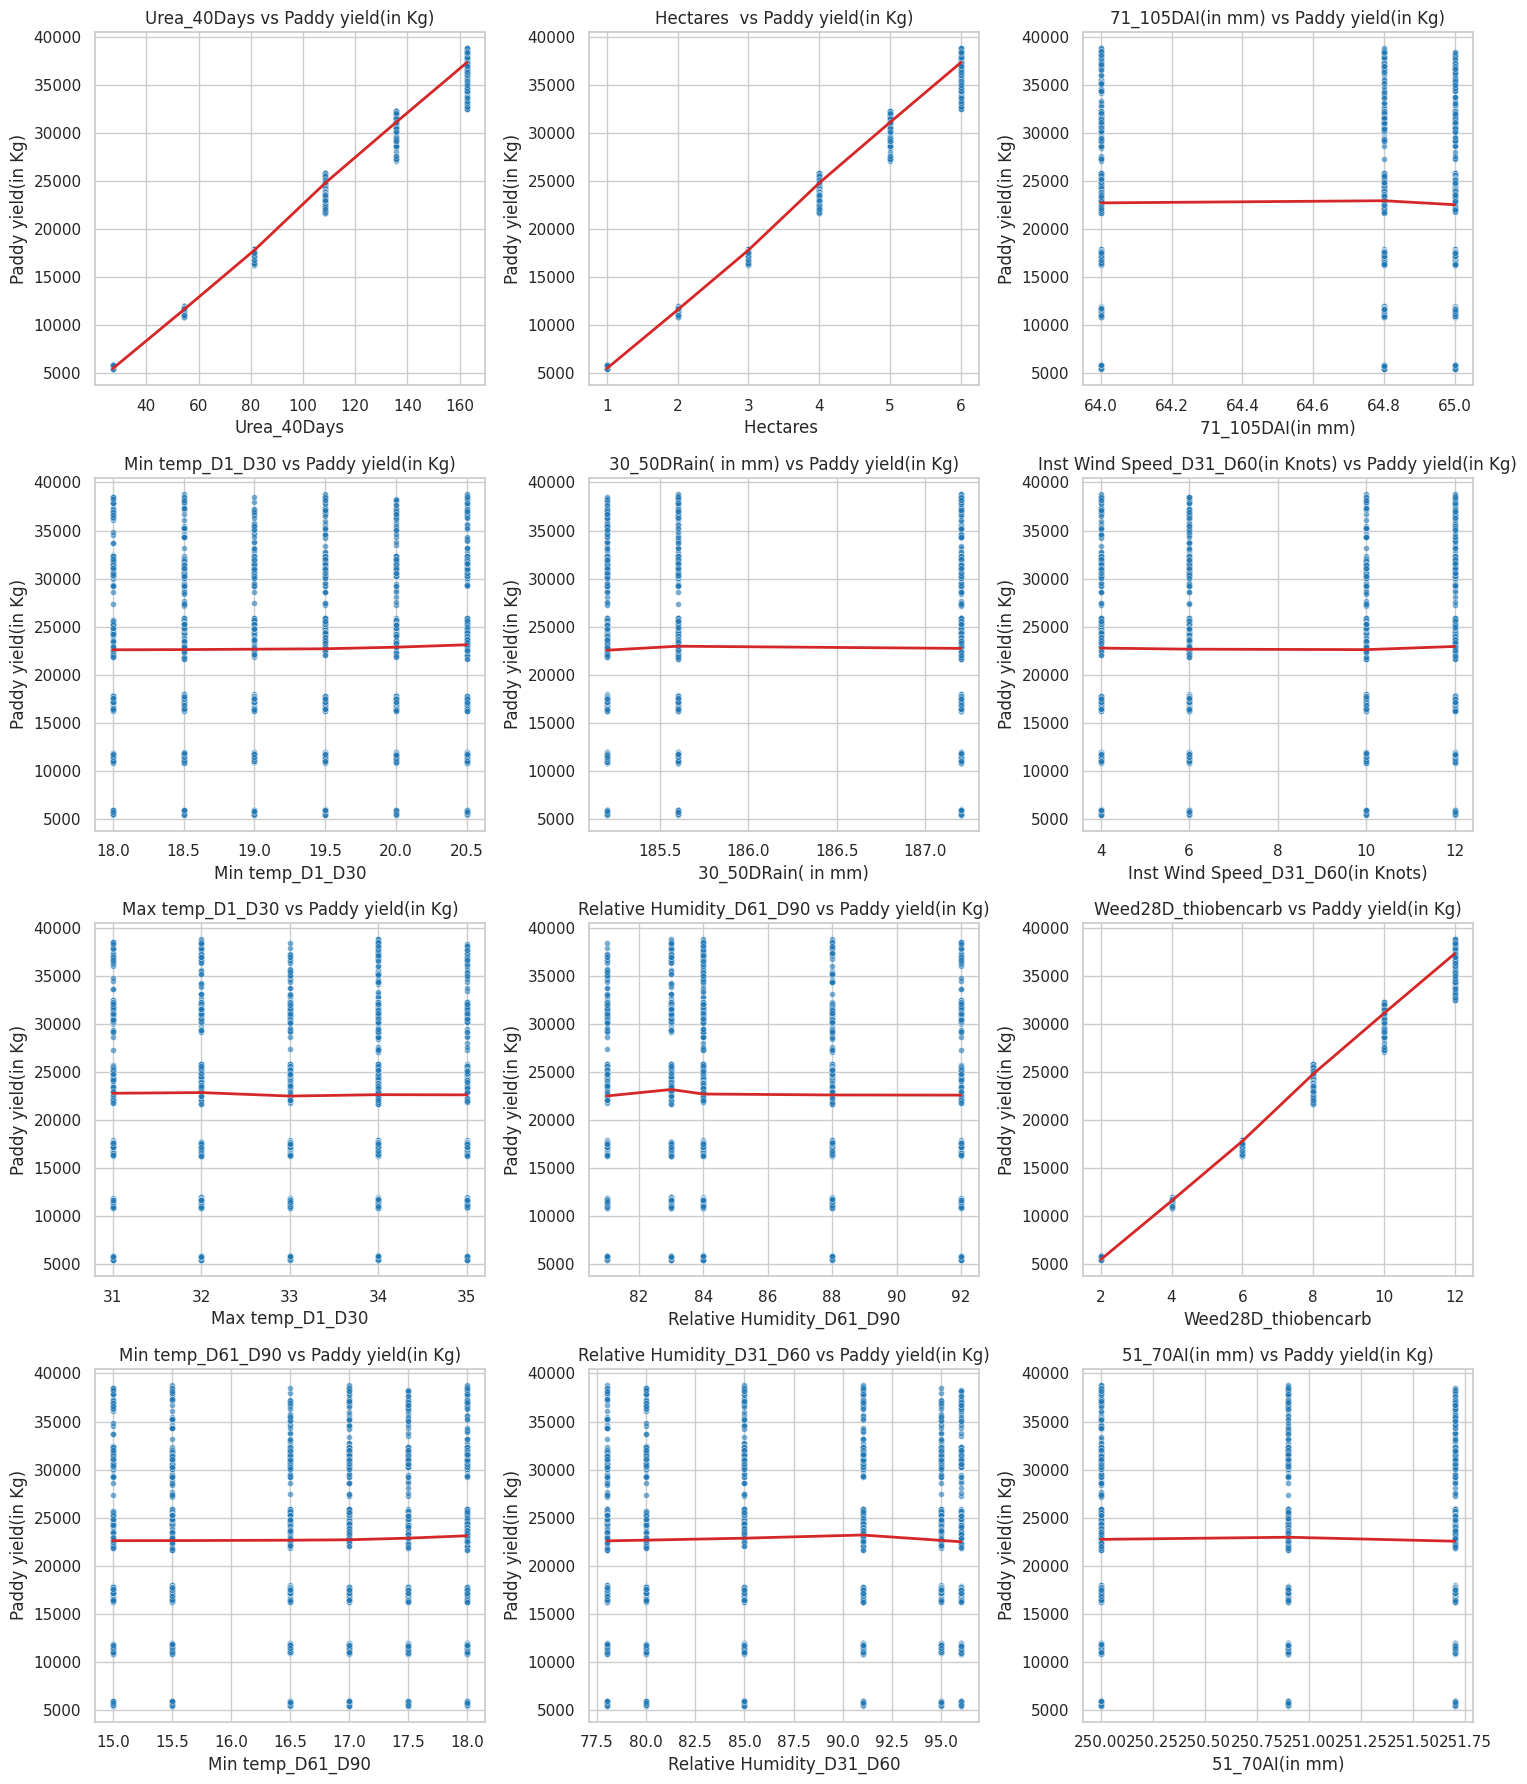

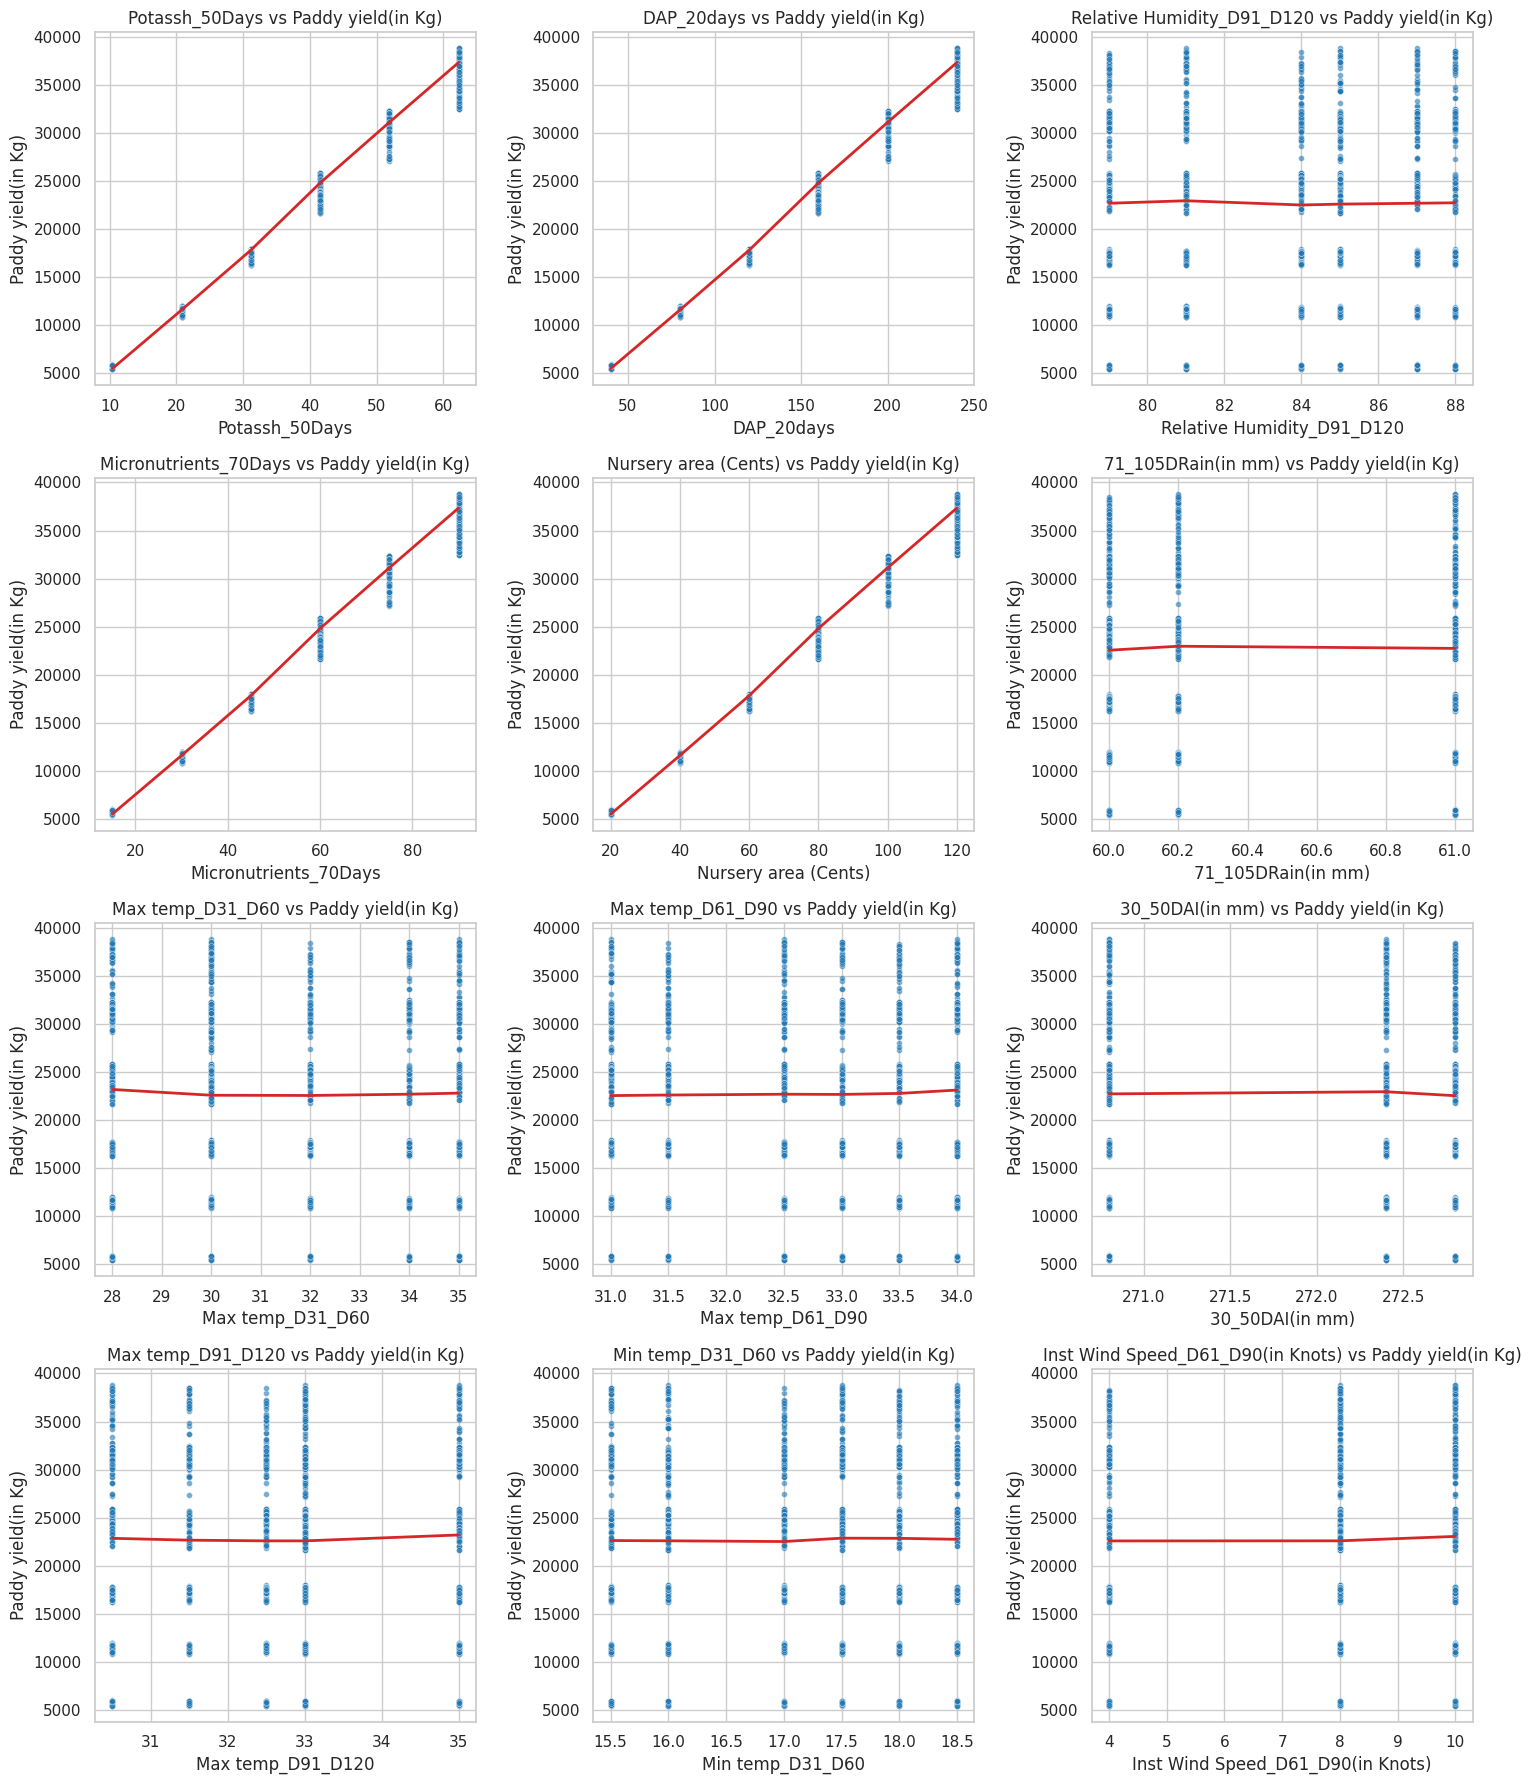

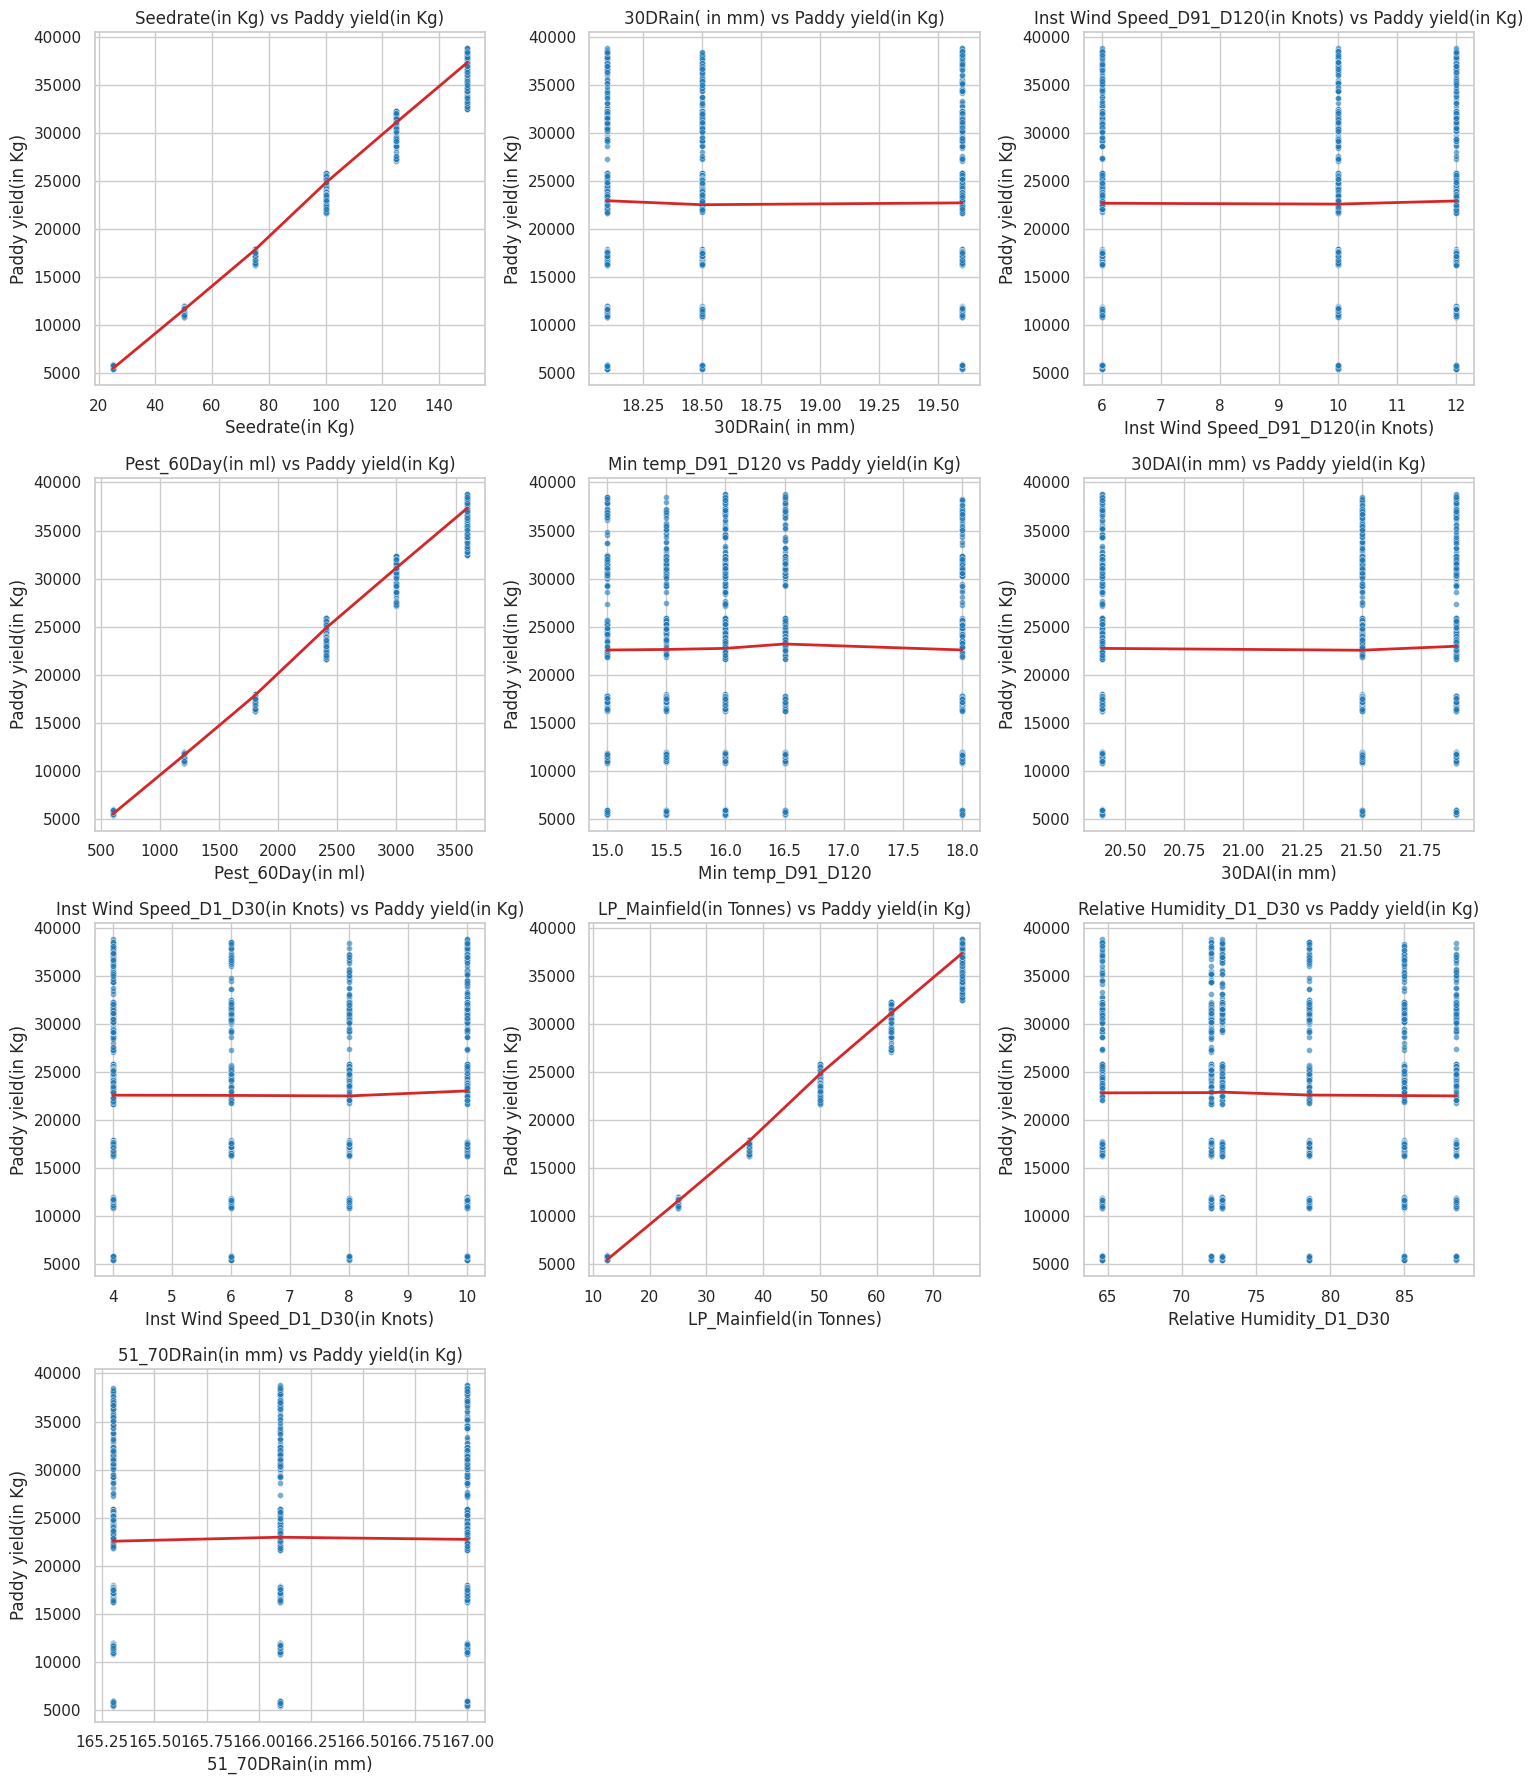

In [23]:

# =========================
# Scatter Plots vs Target (Top-25 features)
# =========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
TARGET = "Paddy yield(in Kg)"

# --- Choose canonical dataframe (prefer df_top25) ---
try:
    base = df_top25.copy()
except NameError:
    try:
        base = data.copy()
    except NameError:
        try:
            base = df_reduced.copy()
        except NameError:
            base = df.copy()

# Ensure target exists and is numeric
if TARGET not in base.columns:
    raise ValueError(f"Target column '{TARGET}' not found in the dataframe.")
base[TARGET] = pd.to_numeric(base[TARGET], errors="coerce")

# --- Numeric features only (exclude the target itself for X) ---
numeric_cols = base.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

print(f"Generating scatter plots for {len(feature_cols)} numeric features vs target.")

# Helper: paginated 4x3 grid of scatterplots with optional LOWESS trend
def plot_scatter_vs_target(df, x_cols, y_col, per_fig=12, rows=4, cols_in_grid=3, lowess=True):
    pages = (len(x_cols) + per_fig - 1) // per_fig
    for p in range(pages):
        subset = x_cols[p*per_fig : min((p+1)*per_fig, len(x_cols))]
        plt.figure(figsize=(15, 18))
        for i, col in enumerate(subset, 1):
            plt.subplot(rows, cols_in_grid, i)
            sns.scatterplot(data=df, x=col, y=y_col, s=18, alpha=0.6, color="#1f77b4")
            # Add LOWESS/line of best fit for visual guidance
            if lowess:
                try:
                    sns.regplot(
                        data=df, x=col, y=y_col,
                        scatter=False, lowess=True, line_kws={"color": "#d62728", "lw": 2}
                    )
                # If LOWESS not available in your seaborn version, fall back to linear fit
                except Exception:
                    sns.regplot(
                        data=df, x=col, y=y_col,
                        scatter=False, line_kws={"color": "#d62728", "lw": 2}
                    )
            plt.title(f"{col} vs {y_col}")
            plt.xlabel(col)
            plt.ylabel(y_col)
        # Turn off unused panels
        for j in range(len(subset)+1, rows*cols_in_grid+1):
            plt.subplot(rows, cols_in_grid, j)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

# Run the plotting function
plot_scatter_vs_target(base, feature_cols, TARGET, per_fig=12, rows=4, cols_in_grid=3, lowess=True)



### EDA Summary

Key observations:

- **Data Integrity:**  
  - No missing values detected in the dataset.  
  - Duplicate columns were removed; no duplicate rows found.  

- **Feature Selection:**  
  - Applied Mutual Information and Random Forest importance to select the top 25 most relevant features for predicting `Paddy yield(in Kg)`.  
  - Retained agronomic inputs (seed rate, fertilizers, pest control), environmental metrics (temperature, humidity, irrigation), and categorical factors (variety, soil type, nursery type).  

- **Distribution Analysis:**  
  - Agronomic features such as `Seedrate(in Kg)`, `Urea_40Days`, and `DAP_20days` show strong scaling with plot size (`Hectares`), indicating multicollinearity.  
  - Environmental features (rainfall, humidity, temperature) exhibit low variability and discrete levels.  

- **Outlier Detection:**  
  - Outliers identified using IQR and Z-score methods; 425 rows flagged by IQR across numeric features.  
  - Outliers primarily occur in scaled agronomic inputs and some irrigation metrics.  

- **Correlation Insights:**  
  - Extremely strong positive correlations (~0.995) between yield and agronomic inputs (area, seed rate, fertilizers, pest control).  
  - Weak or near-zero correlations for rainfall, humidity, and temperature features, suggesting limited predictive power in raw form.  

- **Visual Patterns:**  
  - Scatter plots confirm linear relationships between yield and input quantities, driven by area scaling.  
  - Boxplots highlight skewness and presence of extreme values in input features.  


## Data preprocessing
### Train - Test data split and scaling using Standard Scaling

In [24]:

# =========================
# Train–Test Split + Standard Scaling (numeric features)
# =========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

TARGET = "Paddy yield(in Kg)"

# --- Choose the working dataframe (cleaned top-25 preferred) ---
try:
    base = data_clean.copy()           # if you removed IQR outliers
except NameError:
    try:
        base = df_top25_clean.copy()   # alias used in earlier cell
    except NameError:
        try:
            base = df_top25.copy()     # top-25 features
        except NameError:
            try:
                base = df_reduced.copy()
            except NameError:
                base = df.copy()

# --- Split into X, y ---
if TARGET not in base.columns:
    raise ValueError(f"Target column '{TARGET}' not found in the dataframe.")

# Identify numeric and categorical columns
num_cols = base.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = base.select_dtypes(exclude=[np.number]).columns.tolist()

# Features: keep all columns except target
X = base.drop(columns=[TARGET]).copy()
y = base[TARGET].copy()

# For scaling, only numeric feature columns (avoid scaling categoricals)
num_feature_cols = [c for c in num_cols if c in X.columns]

# --- Train–test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# --- Standard scaling for numeric features ---
scaler = StandardScaler()

# Fit on training numeric columns
X_train_num = X_train[num_feature_cols].astype(float)
X_test_num  = X_test[num_feature_cols].astype(float)

X_train_scaled_num = scaler.fit_transform(X_train_num)
X_test_scaled_num  = scaler.transform(X_test_num)

# Reconstruct DataFrames: scaled numerics + untouched categoricals
X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[num_feature_cols] = X_train_scaled_num
X_test_scaled[num_feature_cols]  = X_test_scaled_num

# For displaying quick stats
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
display(X_train_scaled_df.describe().T)

# OPTIONAL: if you want just the numeric-scaled DataFrames without categoricals
# X_train_scaled_df_num = pd.DataFrame(X_train_scaled_num, columns=num_feature_cols, index=X_train.index)
# X_test_scaled_df_num  = pd.DataFrame(X_test_scaled_num,  columns=num_feature_cols, index=X_test.index)


X_train shape: (1891, 39)
X_test shape : (473, 39)


,count,mean,std,min,25%,50%,75%,max
Urea_40Days,1891.0,-4.311728e-16,1.000265,-1.866975,-0.486815,0.203265,0.893345,1.583425
Hectares,1891.0,-1.136643e-16,1.000265,-1.866975,-0.486815,0.203265,0.893345,1.583425
71_105DAI(in mm),1891.0,8.202617e-15,1.000265,-1.205912,-1.205912,0.671330,0.671330,1.140641
Min temp_D1_D30,1891.0,-7.571357e-16,1.000265,-1.364473,-0.804530,-0.244586,1.435243,1.435243
30_50DRain( in mm),1891.0,2.504936e-14,1.000265,-1.140641,-0.671330,-0.671330,1.205912,1.205912
Inst Wind Speed_D31_D60(in Knots),1891.0,-3.757497e-18,1.000265,-1.258094,-0.610556,-0.610556,1.332060,1.332060
Max temp_D1_D30,1891.0,-2.151167e-15,1.000265,-1.580128,-0.703875,0.172378,1.048630,1.048630
Relative Humidity_D61_D90,1891.0,1.837416e-15,1.000265,-1.168085,-0.633384,-0.366034,0.703368,1.772769
Weed28D_thiobencarb,1891.0,-1.136643e-16,1.000265,-1.866975,-0.486815,0.203265,0.893345,1.583425
Min temp_D61_D90,1891.0,-1.005131e-15,1.000265,-1.400811,-0.944884,-0.033031,1.334748,1.334748



### Summary
- Outliers removed using IQR method (clean dataset used when available).
- Train–test split done with **80/20** ratio (`random_state=42`).
- **StandardScaler** applied to **numeric features only** (categoricals left unscaled).
- Final datasets prepared:
  - `X_train_scaled`, `X_test_scaled` (scaled numerics + original categoricals)
  - `y_train`, `y_test`



## Model Training

We train and evaluate the following models for predicting **CO emissions**:

1. **Linear Regression**  
   - Baseline model for capturing linear relationships.

2. **Regularized Linear Models**  
   - **Ridge Regression** (L2 regularization)  
   - **Lasso Regression** (L1 regularization)  
   - **Elastic Net** (combination of L1 & L2 regularization)  
   - Helps mitigate multicollinearity and improve generalization.

3. **Decision Tree Regressor**  
   - Captures non-linear relationships and feature interactions.

4. **Neural Network (MLPRegressor)**  
   - Multi-layer perceptron for modeling complex patterns.

5. **Random Forest / ExtraTrees**  
   - Ensemble of decision trees for better accuracy and reduced overfitting.

6. **Clustering (Unsupervised)**  
   - **Purpose:**  
     1. Group similar observations for exploratory analysis.  
     2. Add cluster labels as features to improve supervised models.  
     3. Identify patterns or segments influencing emissions.  
     4. Common methods: K-Means, Hierarchical, DBSCAN, Gaussian Mixture Models.

---

### Evaluation Metrics
Performance is reported using:
- **MAE** (Mean Absolute Error)  
- **MSE** (Mean Squared Error)  
- **RMSE** (Root Mean Squared Error)  
- **R² Score** (Coefficient of Determination)


## Linear Regression

In [26]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

lr_pipe = Pipeline([("prep", preprocess), ("model", LinearRegression())])
lr_pipe.fit(X_train_scaled, y_train)
y_pred_lr = lr_pipe.predict(X_test_scaled)

print("Linear Regression (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("MSE :", mean_squared_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R²  :", r2_score(y_test, y_pred_lr))


Linear Regression (OHE + passthrough)
---------------------
MAE : 722.226563186768
MSE : 895388.5163252306
RMSE: 946.249711400342
R²  : 0.9885499144199836


## Regularized Linear Models

### (a) Ridge Regression

In [27]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

ridge_pipe = Pipeline([("prep", preprocess), ("model", Ridge(alpha=1.0, random_state=42))])
ridge_pipe.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_pipe.predict(X_test_scaled)

print("Ridge Regression (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_ridge))
print("MSE :", mean_squared_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R²  :", r2_score(y_test, y_pred_ridge))


Ridge Regression (OHE + passthrough)
---------------------
MAE : 722.2726111319452
MSE : 895459.451633612
RMSE: 946.2871929988338
R²  : 0.9885490073105704


###  (b) Lasso Regression

In [28]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

lasso_pipe = Pipeline([("prep", preprocess), ("model", Lasso(alpha=0.001, random_state=42, max_iter=10000))])
lasso_pipe.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_pipe.predict(X_test_scaled)

print("Lasso Regression (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_lasso))
print("MSE :", mean_squared_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R²  :", r2_score(y_test, y_pred_lasso))


Lasso Regression (OHE + passthrough)
---------------------
MAE : 722.2263406446822
MSE : 895387.7596995737
RMSE: 946.2493115979391
R²  : 0.9885499240955918


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e+07, tolerance: 1.619e+07
  model = cd_fast.enet_coordinate_descent(


### (c) Elastic Net Regression

In [29]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

elastic_pipe = Pipeline([("prep", preprocess), ("model", ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000))])
elastic_pipe.fit(X_train_scaled, y_train)
y_pred_elastic = elastic_pipe.predict(X_test_scaled)

print("Elastic Net (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_elastic))
print("MSE :", mean_squared_error(y_test, y_pred_elastic))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_elastic)))
print("R²  :", r2_score(y_test, y_pred_elastic))


Elastic Net (OHE + passthrough)
---------------------
MAE : 722.6609324501492
MSE : 896073.6926169016
RMSE: 946.6116905135398
R²  : 0.9885411524948148


## Decision Tree



In [30]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

dt_pipe = Pipeline([("prep", preprocess), ("model", DecisionTreeRegressor(max_depth=None, random_state=42))])
dt_pipe.fit(X_train_scaled, y_train)
y_pred_dt = dt_pipe.predict(X_test_scaled)

print("Decision Tree Regressor (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_dt))
print("MSE :", mean_squared_error(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("R²  :", r2_score(y_test, y_pred_dt))


Decision Tree Regressor (OHE + passthrough)
---------------------
MAE : 623.3570557235379
MSE : 734993.6566430802
RMSE: 857.3177104452469
R²  : 0.9906010183111666


## Neural Network

In [31]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

mlp_pipe = Pipeline([
    ("prep", preprocess),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate='adaptive',
        max_iter=1000,
        random_state=42
    ))
])
mlp_pipe.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_pipe.predict(X_test_scaled)

print("MLPRegressor (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_mlp))
print("MSE :", mean_squared_error(y_test, y_pred_mlp))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))
print("R²  :", r2_score(y_test, y_pred_mlp))


MLPRegressor (OHE + passthrough)
---------------------
MAE : 654.5356208153574
MSE : 811059.9106373148
RMSE: 900.5886467401833
R²  : 0.9896282951836022


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Random Forest

In [32]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

rf_pipe = Pipeline([("prep", preprocess), ("model", RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1))])
rf_pipe.fit(X_train_scaled, y_train)
y_pred_rf = rf_pipe.predict(X_test_scaled)

print("Random Forest Regressor (OHE + passthrough)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_rf))
print("MSE :", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²  :", r2_score(y_test, y_pred_rf))


Random Forest Regressor (OHE + passthrough)
---------------------
MAE : 618.0328070908118
MSE : 720796.985669188
RMSE: 848.9976358442866
R²  : 0.9907825630759683


## Clustering

In [33]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Build a preprocessing for original features (OHE categoricals + passthrough numerics)
categorical_features = [c for c in cat_cols if c in X_train_scaled.columns]
numeric_features     = [c for c in num_feature_cols if c in X_train_scaled.columns]

base_preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

# 2) Fit base_preprocess to obtain numeric arrays for KMeans
X_train_base = base_preprocess.fit_transform(X_train_scaled)
X_test_base  = base_preprocess.transform(X_test_scaled)

# 3) K-Means clustering on the preprocessed feature space
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_base)
test_clusters  = kmeans.predict(X_test_base)

# 4) One-hot encode the cluster labels and augment the arrays
ohe_clusters = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_cl_ohe = ohe_clusters.fit_transform(train_clusters.reshape(-1, 1))
test_cl_ohe  = ohe_clusters.transform(test_clusters.reshape(-1, 1))

X_train_aug = np.hstack([X_train_base, train_cl_ohe])
X_test_aug  = np.hstack([X_test_base,  test_cl_ohe])

# 5) Fit a regressor on augmented features (Random Forest example)
rf_aug = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_aug.fit(X_train_aug, y_train)
y_pred_rf_aug = rf_aug.predict(X_test_aug)

print("Random Forest (with K-Means cluster features)")
print("---------------------")
print("MAE :", mean_absolute_error(y_test, y_pred_rf_aug))
print("MSE :", mean_squared_error(y_test, y_pred_rf_aug))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_aug)))
print("R²  :", r2_score(y_test, y_pred_rf_aug))


Random Forest (with K-Means cluster features)
---------------------
MAE : 618.0093521456631
MSE : 720814.3711487076
RMSE: 849.0078746093628
R²  : 0.9907823407532284


Actual Vs Predicted Plots

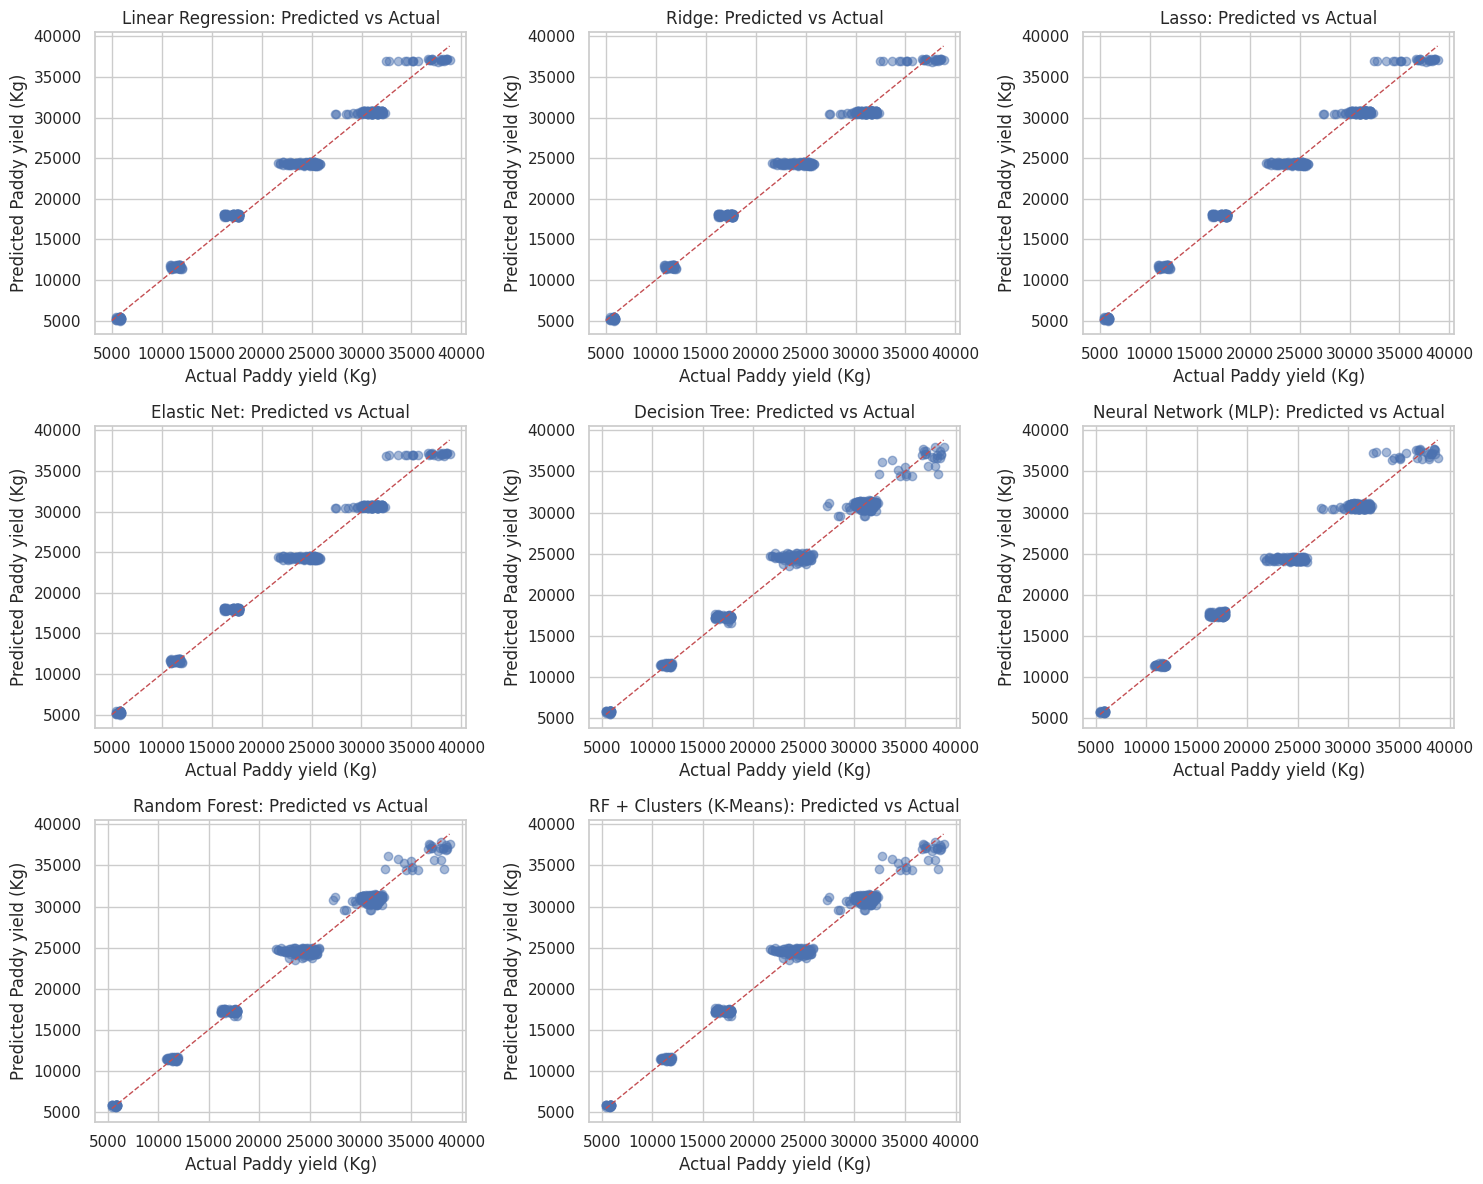

In [34]:

import matplotlib.pyplot as plt

TARGET_LABEL = "Paddy yield (Kg)"  # axis label text

# Collect available predictions (only those that are defined in the environment)
models_preds = []

try:
    models_preds.append(("Linear Regression", y_pred_lr))
except NameError:
    pass

try:
    models_preds.append(("Ridge", y_pred_ridge))
except NameError:
    pass

try:
    models_preds.append(("Lasso", y_pred_lasso))
except NameError:
    pass

try:
    models_preds.append(("Elastic Net", y_pred_elastic))
except NameError:
    pass

try:
    models_preds.append(("Decision Tree", y_pred_dt))
except NameError:
    # some users name it y_pred_tree; add fallback
    try:
        models_preds.append(("Decision Tree", y_pred_tree))
    except NameError:
        pass

try:
    models_preds.append(("Neural Network (MLP)", y_pred_mlp))
except NameError:
    pass

try:
    models_preds.append(("Random Forest", y_pred_rf))
except NameError:
    pass

try:
    models_preds.append(("ExtraTrees", y_pred_etr))
except NameError:
    pass

try:
    models_preds.append(("RF + Clusters (K-Means)", y_pred_rf_aug))
except NameError:
    pass

# If nothing is available, warn and skip
if len(models_preds) == 0:
    print("No prediction variables found (e.g., y_pred_lr, y_pred_ridge, ...). Train models first.")
else:
    # Determine nice grid size: up to 3 columns, enough rows
    n_plots = len(models_preds)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, (model_name, y_pred) in enumerate(models_preds, 1):
        plt.subplot(n_rows, n_cols, i)
        plt.scatter(y_test, y_pred, alpha=0.5)
        # 45-degree reference line
        ymin, ymax = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        plt.plot([ymin, ymax], [ymin, ymax], 'r--', linewidth=1)

        plt.xlabel(f"Actual {TARGET_LABEL}")
        plt.ylabel(f"Predicted {TARGET_LABEL}")
        plt.title(f"{model_name}: Predicted vs Actual")

    plt.tight_layout()
    plt.show()



## Model Performance Summary

| Model                        | MAE        | MSE           | RMSE       | R²        |
|-----------------------------|-----------|--------------|-----------|-----------|
| **Random Forest**           | 618.032807 | 720796.985669 | **848.997636** | **0.990783** |
| RF + Clusters (K-Means)    | 618.009352 | 720814.371149 | 849.007875 | 0.990782 |
| Decision Tree              | 623.357056 | 734993.656643 | 857.317710 | 0.990601 |
| Neural Network (MLP)       | 654.535621 | 811059.910637 | 900.588647 | 0.989628 |
| Lasso Regression           | 722.226341 | 895387.759700 | 946.249312 | 0.988550 |
| Linear Regression          | 722.226563 | 895388.516325 | 946.249711 | 0.988550 |
| Ridge Regression           | 722.272611 | 895459.451634 | 946.287193 | 0.988549 |
| Elastic Net                | 722.660932 | 896073.692617 | 946.611691 | 0.988541 |

---

### Why is R² so High for All Models?

- **Deterministic relationship**: Paddy yield is almost perfectly explained by plot size and input quantities (seed, fertilizers, pesticides), which scale linearly with area.  
- **Feature selection retained highly predictive variables**: Mutual Information and Random Forest importance ensured only strong predictors remain.  
- **Low noise and low variability in environmental features**: Weather and irrigation data have limited variation, reducing unpredictability.  
- **Effectively linear scaling**: Larger area → more inputs → higher yield, making even simple models achieve near-perfect fit.  

---

## Summary

- The **Random Forest** model performs the best overall, achieving the lowest RMSE (≈849) and highest R² (≈0.9908), though the improvement over other models is marginal because the dataset is highly predictable.  
- **RF + Clusters (K-Means)** shows almost identical performance to Random Forest, indicating clustering adds little benefit when the main drivers are already captured by agronomic inputs.  
- **Decision Tree** performs slightly worse than Random Forest but still achieves an excellent R² (>0.9906).  
- **Neural Network (MLP)** performs well but does not surpass tree-based models, likely because the relationships are mostly linear and scale-driven.  
- **Linear Regression, Ridge, Lasso, and Elastic Net** all perform similarly with R² ≈0.9885, confirming that regularization has minimal impact because multicollinearity does not harm predictive accuracy in this context.  
- Overall, all models achieve very high R² (>0.98) because paddy yield is almost perfectly explained by area and input quantities. Models capable of handling non-linearities (Random Forest, Decision Tree) offer slight improvements, but the dataset’s deterministic nature limits the performance gap.  
